In [1]:
import gymnasium as gym
import numpy as np
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gymnasium[atari,accept-rom-license] ale-py AutoROM AutoROM.accept-rom-license --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 28.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Licensing

In [3]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


#Creating Environment

In [4]:
import gymnasium as gym
import ale_py

# Check registration
print("ALE registered?", "ALE" in gym.envs.registry)

# Create environment
env = gym.make("ALE/Alien-v5", render_mode="rgb_array")
obs, info = env.reset()
print("✅ Environment loaded successfully!")
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

ALE registered? False
✅ Environment loaded successfully!
Action space: Discrete(18)
Observation space: Box(0, 255, (210, 160, 3), uint8)


#FRAME PREPROCESSING

In [5]:
import cv2
import numpy as np

def preprocess_frame(frame):
    """Convert RGB to grayscale and resize to 84x84"""
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84))
    return np.array(resized, dtype=np.uint8)

#Defining DeepQ

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = x / 255.0
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


#Initialize the DQN Networks and Optimizer

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_actions = env.action_space.n
policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)


#Implement Replay Buffer

In [8]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
    def add(self, s,a,r,ns,d):
        self.buffer.append((s,a,r,ns,d))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s,a,r,ns,d = map(np.array, zip(*batch))
        return s,a,r,ns,d
    def __len__(self):
        return len(self.buffer)


#Training Loop

In [10]:
memory = ReplayBuffer(10000)
GAMMA = 0.99
EPS = 1.0
EPS_MIN = 0.1
DECAY = 0.996
BATCH_SIZE = 64
TARGET_UPDATE = 500
EPISODES = 2000
MAX_STEPS = 1000

def choose_action(state, epsilon):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    state_t = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        return policy_net(state_t).argmax().item()

rewards = []

for ep in range(EPISODES):
    s, info = env.reset()
    s = preprocess_frame(s)
    total_reward = 0

    for step in range(MAX_STEPS):
        a = choose_action(s, EPS)
        s2, r, done, trunc, info = env.step(a)
        s2 = preprocess_frame(s2)
        memory.add(s, a, r, s2, done)
        s = s2
        total_reward += r

        if len(memory) > BATCH_SIZE:
            ss, aa, rr, s2s, dd = memory.sample(BATCH_SIZE)
            ss = torch.FloatTensor(ss).unsqueeze(1).to(device)
            s2s = torch.FloatTensor(s2s).unsqueeze(1).to(device)
            aa = torch.LongTensor(aa).to(device)
            rr = torch.FloatTensor(rr).to(device)
            dd = torch.FloatTensor(dd).to(device)

            q_vals = policy_net(ss).gather(1, aa.unsqueeze(1)).squeeze(1)
            next_q = target_net(s2s).max(1)[0]
            expected_q = rr + GAMMA * next_q * (1 - dd)

            loss = nn.MSELoss()(q_vals, expected_q.detach())
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        if step % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done: break

    EPS = max(EPS_MIN, EPS * DECAY)
    rewards.append(total_reward)
    print(f"Episode {ep+1}/{EPISODES}, Reward: {total_reward:.1f}, Epsilon: {EPS:.3f}")


Episode 1/2000, Reward: 160.0, Epsilon: 0.996
Episode 2/2000, Reward: 210.0, Epsilon: 0.992
Episode 3/2000, Reward: 150.0, Epsilon: 0.988
Episode 4/2000, Reward: 220.0, Epsilon: 0.984
Episode 5/2000, Reward: 210.0, Epsilon: 0.980
Episode 6/2000, Reward: 160.0, Epsilon: 0.976
Episode 7/2000, Reward: 260.0, Epsilon: 0.972
Episode 8/2000, Reward: 200.0, Epsilon: 0.968
Episode 9/2000, Reward: 230.0, Epsilon: 0.965
Episode 10/2000, Reward: 130.0, Epsilon: 0.961
Episode 11/2000, Reward: 150.0, Epsilon: 0.957
Episode 12/2000, Reward: 190.0, Epsilon: 0.953
Episode 13/2000, Reward: 220.0, Epsilon: 0.949
Episode 14/2000, Reward: 130.0, Epsilon: 0.945
Episode 15/2000, Reward: 210.0, Epsilon: 0.942
Episode 16/2000, Reward: 130.0, Epsilon: 0.938
Episode 17/2000, Reward: 190.0, Epsilon: 0.934
Episode 18/2000, Reward: 230.0, Epsilon: 0.930
Episode 19/2000, Reward: 220.0, Epsilon: 0.927
Episode 20/2000, Reward: 230.0, Epsilon: 0.923
Episode 21/2000, Reward: 120.0, Epsilon: 0.919
Episode 22/2000, Rewar

#Performance Visualization and Evaluation

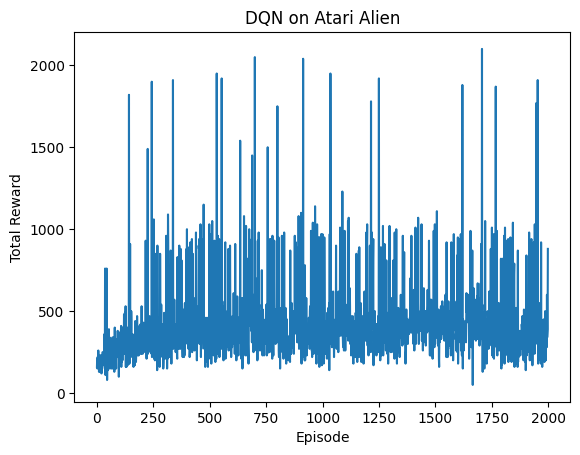

In [11]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN on Atari Alien')
plt.show()


#Import the game to MP4

In [12]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# Create a video folder in your workspace
env = RecordVideo(
    gym.make("ALE/Alien-v5", render_mode="rgb_array"),
    video_folder="./alien_videos",
    episode_trigger=lambda ep: True  # record every episode
)

s, info = env.reset()
done = False
while not done:
    s = preprocess_frame(s)
    a = choose_action(s, 0.05)  # almost-greedy
    s, r, done, trunc, info = env.step(a)
env.close()


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


In [13]:
from IPython.display import Video
Video("./alien_videos/rl-video-episode-0.mp4", embed=True)


In [1]:
import re


log_text = """ Episode 1/2000, Reward: 160.0, Epsilon: 0.996
Episode 2/2000, Reward: 210.0, Epsilon: 0.992
Episode 3/2000, Reward: 150.0, Epsilon: 0.988
Episode 4/2000, Reward: 220.0, Epsilon: 0.984
Episode 5/2000, Reward: 210.0, Epsilon: 0.980
Episode 6/2000, Reward: 160.0, Epsilon: 0.976
Episode 7/2000, Reward: 260.0, Epsilon: 0.972
Episode 8/2000, Reward: 200.0, Epsilon: 0.968
Episode 9/2000, Reward: 230.0, Epsilon: 0.965
Episode 10/2000, Reward: 130.0, Epsilon: 0.961
Episode 11/2000, Reward: 150.0, Epsilon: 0.957
Episode 12/2000, Reward: 190.0, Epsilon: 0.953
Episode 13/2000, Reward: 220.0, Epsilon: 0.949
Episode 14/2000, Reward: 130.0, Epsilon: 0.945
Episode 15/2000, Reward: 210.0, Epsilon: 0.942
Episode 16/2000, Reward: 130.0, Epsilon: 0.938
Episode 17/2000, Reward: 190.0, Epsilon: 0.934
Episode 18/2000, Reward: 230.0, Epsilon: 0.930
Episode 19/2000, Reward: 220.0, Epsilon: 0.927
Episode 20/2000, Reward: 230.0, Epsilon: 0.923
Episode 21/2000, Reward: 120.0, Epsilon: 0.919
Episode 22/2000, Reward: 150.0, Epsilon: 0.916
Episode 23/2000, Reward: 160.0, Epsilon: 0.912
Episode 24/2000, Reward: 200.0, Epsilon: 0.908
Episode 25/2000, Reward: 190.0, Epsilon: 0.905
Episode 26/2000, Reward: 250.0, Epsilon: 0.901
Episode 27/2000, Reward: 250.0, Epsilon: 0.897
Episode 28/2000, Reward: 190.0, Epsilon: 0.894
Episode 29/2000, Reward: 170.0, Epsilon: 0.890
Episode 30/2000, Reward: 180.0, Epsilon: 0.887
Episode 31/2000, Reward: 180.0, Epsilon: 0.883
Episode 32/2000, Reward: 200.0, Epsilon: 0.880
Episode 33/2000, Reward: 210.0, Epsilon: 0.876
Episode 34/2000, Reward: 360.0, Epsilon: 0.873
Episode 35/2000, Reward: 360.0, Epsilon: 0.869
Episode 36/2000, Reward: 150.0, Epsilon: 0.866
Episode 37/2000, Reward: 760.0, Epsilon: 0.862
Episode 38/2000, Reward: 120.0, Epsilon: 0.859
Episode 39/2000, Reward: 110.0, Epsilon: 0.855
Episode 40/2000, Reward: 220.0, Epsilon: 0.852
Episode 41/2000, Reward: 250.0, Epsilon: 0.848
Episode 42/2000, Reward: 150.0, Epsilon: 0.845
Episode 43/2000, Reward: 130.0, Epsilon: 0.842
Episode 44/2000, Reward: 760.0, Epsilon: 0.838
Episode 45/2000, Reward: 220.0, Epsilon: 0.835
Episode 46/2000, Reward: 80.0, Epsilon: 0.832
Episode 47/2000, Reward: 180.0, Epsilon: 0.828
Episode 48/2000, Reward: 210.0, Epsilon: 0.825
Episode 49/2000, Reward: 160.0, Epsilon: 0.822
Episode 50/2000, Reward: 140.0, Epsilon: 0.818
Episode 51/2000, Reward: 250.0, Epsilon: 0.815
Episode 52/2000, Reward: 200.0, Epsilon: 0.812
Episode 53/2000, Reward: 250.0, Epsilon: 0.809
Episode 54/2000, Reward: 390.0, Epsilon: 0.805
Episode 55/2000, Reward: 270.0, Epsilon: 0.802
Episode 56/2000, Reward: 210.0, Epsilon: 0.799
Episode 57/2000, Reward: 340.0, Epsilon: 0.796
Episode 58/2000, Reward: 150.0, Epsilon: 0.793
Episode 59/2000, Reward: 190.0, Epsilon: 0.789
Episode 60/2000, Reward: 270.0, Epsilon: 0.786
Episode 61/2000, Reward: 310.0, Epsilon: 0.783
Episode 62/2000, Reward: 160.0, Epsilon: 0.780
Episode 63/2000, Reward: 240.0, Epsilon: 0.777
Episode 64/2000, Reward: 200.0, Epsilon: 0.774
Episode 65/2000, Reward: 150.0, Epsilon: 0.771
Episode 66/2000, Reward: 160.0, Epsilon: 0.768
Episode 67/2000, Reward: 180.0, Epsilon: 0.764
Episode 68/2000, Reward: 240.0, Epsilon: 0.761
Episode 69/2000, Reward: 240.0, Epsilon: 0.758
Episode 70/2000, Reward: 340.0, Epsilon: 0.755
Episode 71/2000, Reward: 150.0, Epsilon: 0.752
Episode 72/2000, Reward: 240.0, Epsilon: 0.749
Episode 73/2000, Reward: 330.0, Epsilon: 0.746
Episode 74/2000, Reward: 230.0, Epsilon: 0.743
Episode 75/2000, Reward: 340.0, Epsilon: 0.740
Episode 76/2000, Reward: 260.0, Epsilon: 0.737
Episode 77/2000, Reward: 270.0, Epsilon: 0.734
Episode 78/2000, Reward: 130.0, Epsilon: 0.732
Episode 79/2000, Reward: 210.0, Epsilon: 0.729
Episode 80/2000, Reward: 400.0, Epsilon: 0.726
Episode 81/2000, Reward: 220.0, Epsilon: 0.723
Episode 82/2000, Reward: 200.0, Epsilon: 0.720
Episode 83/2000, Reward: 170.0, Epsilon: 0.717
Episode 84/2000, Reward: 230.0, Epsilon: 0.714
Episode 85/2000, Reward: 230.0, Epsilon: 0.711
Episode 86/2000, Reward: 150.0, Epsilon: 0.708
Episode 87/2000, Reward: 280.0, Epsilon: 0.706
Episode 88/2000, Reward: 330.0, Epsilon: 0.703
Episode 89/2000, Reward: 330.0, Epsilon: 0.700
Episode 90/2000, Reward: 300.0, Epsilon: 0.697
Episode 91/2000, Reward: 290.0, Epsilon: 0.694
Episode 92/2000, Reward: 220.0, Epsilon: 0.692
Episode 93/2000, Reward: 380.0, Epsilon: 0.689
Episode 94/2000, Reward: 220.0, Epsilon: 0.686
Episode 95/2000, Reward: 280.0, Epsilon: 0.683
Episode 96/2000, Reward: 220.0, Epsilon: 0.681
Episode 97/2000, Reward: 290.0, Epsilon: 0.678
Episode 98/2000, Reward: 100.0, Epsilon: 0.675
Episode 99/2000, Reward: 190.0, Epsilon: 0.672
Episode 100/2000, Reward: 370.0, Epsilon: 0.670
Episode 101/2000, Reward: 360.0, Epsilon: 0.667
Episode 102/2000, Reward: 320.0, Epsilon: 0.664
Episode 103/2000, Reward: 270.0, Epsilon: 0.662
Episode 104/2000, Reward: 190.0, Epsilon: 0.659
Episode 105/2000, Reward: 260.0, Epsilon: 0.656
Episode 106/2000, Reward: 230.0, Epsilon: 0.654
Episode 107/2000, Reward: 360.0, Epsilon: 0.651
Episode 108/2000, Reward: 410.0, Epsilon: 0.649
Episode 109/2000, Reward: 160.0, Epsilon: 0.646
Episode 110/2000, Reward: 290.0, Epsilon: 0.643
Episode 111/2000, Reward: 190.0, Epsilon: 0.641
Episode 112/2000, Reward: 230.0, Epsilon: 0.638
Episode 113/2000, Reward: 350.0, Epsilon: 0.636
Episode 114/2000, Reward: 200.0, Epsilon: 0.633
Episode 115/2000, Reward: 400.0, Epsilon: 0.631
Episode 116/2000, Reward: 250.0, Epsilon: 0.628
Episode 117/2000, Reward: 280.0, Epsilon: 0.626
Episode 118/2000, Reward: 300.0, Epsilon: 0.623
Episode 119/2000, Reward: 340.0, Epsilon: 0.621
Episode 120/2000, Reward: 290.0, Epsilon: 0.618
Episode 121/2000, Reward: 480.0, Epsilon: 0.616
Episode 122/2000, Reward: 240.0, Epsilon: 0.613
Episode 123/2000, Reward: 310.0, Epsilon: 0.611
Episode 124/2000, Reward: 240.0, Epsilon: 0.608
Episode 125/2000, Reward: 490.0, Epsilon: 0.606
Episode 126/2000, Reward: 270.0, Epsilon: 0.603
Episode 127/2000, Reward: 250.0, Epsilon: 0.601
Episode 128/2000, Reward: 530.0, Epsilon: 0.599
Episode 129/2000, Reward: 160.0, Epsilon: 0.596
Episode 130/2000, Reward: 350.0, Epsilon: 0.594
Episode 131/2000, Reward: 320.0, Epsilon: 0.592
Episode 132/2000, Reward: 160.0, Epsilon: 0.589
Episode 133/2000, Reward: 270.0, Epsilon: 0.587
Episode 134/2000, Reward: 310.0, Epsilon: 0.584
Episode 135/2000, Reward: 200.0, Epsilon: 0.582
Episode 136/2000, Reward: 220.0, Epsilon: 0.580
Episode 137/2000, Reward: 170.0, Epsilon: 0.577
Episode 138/2000, Reward: 400.0, Epsilon: 0.575
Episode 139/2000, Reward: 280.0, Epsilon: 0.573
Episode 140/2000, Reward: 270.0, Epsilon: 0.571
Episode 141/2000, Reward: 320.0, Epsilon: 0.568
Episode 142/2000, Reward: 180.0, Epsilon: 0.566
Episode 143/2000, Reward: 1820.0, Epsilon: 0.564
Episode 144/2000, Reward: 280.0, Epsilon: 0.561
Episode 145/2000, Reward: 180.0, Epsilon: 0.559
Episode 146/2000, Reward: 190.0, Epsilon: 0.557
Episode 147/2000, Reward: 330.0, Epsilon: 0.555
Episode 148/2000, Reward: 910.0, Epsilon: 0.553
Episode 149/2000, Reward: 330.0, Epsilon: 0.550
Episode 150/2000, Reward: 270.0, Epsilon: 0.548
Episode 151/2000, Reward: 220.0, Epsilon: 0.546
Episode 152/2000, Reward: 370.0, Epsilon: 0.544
Episode 153/2000, Reward: 500.0, Epsilon: 0.542
Episode 154/2000, Reward: 440.0, Epsilon: 0.539
Episode 155/2000, Reward: 240.0, Epsilon: 0.537
Episode 156/2000, Reward: 310.0, Epsilon: 0.535
Episode 157/2000, Reward: 360.0, Epsilon: 0.533
Episode 158/2000, Reward: 260.0, Epsilon: 0.531
Episode 159/2000, Reward: 360.0, Epsilon: 0.529
Episode 160/2000, Reward: 220.0, Epsilon: 0.527
Episode 161/2000, Reward: 310.0, Epsilon: 0.525
Episode 162/2000, Reward: 270.0, Epsilon: 0.522
Episode 163/2000, Reward: 160.0, Epsilon: 0.520
Episode 164/2000, Reward: 280.0, Epsilon: 0.518
Episode 165/2000, Reward: 250.0, Epsilon: 0.516
Episode 166/2000, Reward: 330.0, Epsilon: 0.514
Episode 167/2000, Reward: 300.0, Epsilon: 0.512
Episode 168/2000, Reward: 200.0, Epsilon: 0.510
Episode 169/2000, Reward: 170.0, Epsilon: 0.508
Episode 170/2000, Reward: 220.0, Epsilon: 0.506
Episode 171/2000, Reward: 440.0, Epsilon: 0.504
Episode 172/2000, Reward: 250.0, Epsilon: 0.502
Episode 173/2000, Reward: 290.0, Epsilon: 0.500
Episode 174/2000, Reward: 190.0, Epsilon: 0.498
Episode 175/2000, Reward: 230.0, Epsilon: 0.496
Episode 176/2000, Reward: 340.0, Epsilon: 0.494
Episode 177/2000, Reward: 240.0, Epsilon: 0.492
Episode 178/2000, Reward: 280.0, Epsilon: 0.490
Episode 179/2000, Reward: 470.0, Epsilon: 0.488
Episode 180/2000, Reward: 370.0, Epsilon: 0.486
Episode 181/2000, Reward: 410.0, Epsilon: 0.484
Episode 182/2000, Reward: 230.0, Epsilon: 0.482
Episode 183/2000, Reward: 240.0, Epsilon: 0.480
Episode 184/2000, Reward: 250.0, Epsilon: 0.478
Episode 185/2000, Reward: 350.0, Epsilon: 0.476
Episode 186/2000, Reward: 230.0, Epsilon: 0.475
Episode 187/2000, Reward: 380.0, Epsilon: 0.473
Episode 188/2000, Reward: 280.0, Epsilon: 0.471
Episode 189/2000, Reward: 260.0, Epsilon: 0.469
Episode 190/2000, Reward: 370.0, Epsilon: 0.467
Episode 191/2000, Reward: 300.0, Epsilon: 0.465
Episode 192/2000, Reward: 250.0, Epsilon: 0.463
Episode 193/2000, Reward: 260.0, Epsilon: 0.461
Episode 194/2000, Reward: 420.0, Epsilon: 0.460
Episode 195/2000, Reward: 260.0, Epsilon: 0.458
Episode 196/2000, Reward: 240.0, Epsilon: 0.456
Episode 197/2000, Reward: 330.0, Epsilon: 0.454
Episode 198/2000, Reward: 240.0, Epsilon: 0.452
Episode 199/2000, Reward: 530.0, Epsilon: 0.450
Episode 200/2000, Reward: 280.0, Epsilon: 0.449
Episode 201/2000, Reward: 330.0, Epsilon: 0.447
Episode 202/2000, Reward: 370.0, Epsilon: 0.445
Episode 203/2000, Reward: 270.0, Epsilon: 0.443
Episode 204/2000, Reward: 240.0, Epsilon: 0.441
Episode 205/2000, Reward: 280.0, Epsilon: 0.440
Episode 206/2000, Reward: 330.0, Epsilon: 0.438
Episode 207/2000, Reward: 430.0, Epsilon: 0.436
Episode 208/2000, Reward: 370.0, Epsilon: 0.434
Episode 209/2000, Reward: 250.0, Epsilon: 0.433
Episode 210/2000, Reward: 280.0, Epsilon: 0.431
Episode 211/2000, Reward: 260.0, Epsilon: 0.429
Episode 212/2000, Reward: 380.0, Epsilon: 0.428
Episode 213/2000, Reward: 300.0, Epsilon: 0.426
Episode 214/2000, Reward: 280.0, Epsilon: 0.424
Episode 215/2000, Reward: 360.0, Epsilon: 0.422
Episode 216/2000, Reward: 360.0, Epsilon: 0.421
Episode 217/2000, Reward: 930.0, Epsilon: 0.419
Episode 218/2000, Reward: 370.0, Epsilon: 0.417
Episode 219/2000, Reward: 300.0, Epsilon: 0.416
Episode 220/2000, Reward: 330.0, Epsilon: 0.414
Episode 221/2000, Reward: 210.0, Epsilon: 0.412
Episode 222/2000, Reward: 590.0, Epsilon: 0.411
Episode 223/2000, Reward: 320.0, Epsilon: 0.409
Episode 224/2000, Reward: 270.0, Epsilon: 0.407
Episode 225/2000, Reward: 440.0, Epsilon: 0.406
Episode 226/2000, Reward: 1490.0, Epsilon: 0.404
Episode 227/2000, Reward: 240.0, Epsilon: 0.403
Episode 228/2000, Reward: 300.0, Epsilon: 0.401
Episode 229/2000, Reward: 320.0, Epsilon: 0.399
Episode 230/2000, Reward: 250.0, Epsilon: 0.398
Episode 231/2000, Reward: 310.0, Epsilon: 0.396
Episode 232/2000, Reward: 270.0, Epsilon: 0.395
Episode 233/2000, Reward: 310.0, Epsilon: 0.393
Episode 234/2000, Reward: 470.0, Epsilon: 0.391
Episode 235/2000, Reward: 380.0, Epsilon: 0.390
Episode 236/2000, Reward: 350.0, Epsilon: 0.388
Episode 237/2000, Reward: 270.0, Epsilon: 0.387
Episode 238/2000, Reward: 430.0, Epsilon: 0.385
Episode 239/2000, Reward: 280.0, Epsilon: 0.384
Episode 240/2000, Reward: 300.0, Epsilon: 0.382
Episode 241/2000, Reward: 330.0, Epsilon: 0.381
Episode 242/2000, Reward: 280.0, Epsilon: 0.379
Episode 243/2000, Reward: 240.0, Epsilon: 0.378
Episode 244/2000, Reward: 1900.0, Epsilon: 0.376
Episode 245/2000, Reward: 220.0, Epsilon: 0.375
Episode 246/2000, Reward: 370.0, Epsilon: 0.373
Episode 247/2000, Reward: 310.0, Epsilon: 0.372
Episode 248/2000, Reward: 260.0, Epsilon: 0.370
Episode 249/2000, Reward: 410.0, Epsilon: 0.369
Episode 250/2000, Reward: 350.0, Epsilon: 0.367
Episode 251/2000, Reward: 360.0, Epsilon: 0.366
Episode 252/2000, Reward: 250.0, Epsilon: 0.364
Episode 253/2000, Reward: 1060.0, Epsilon: 0.363
Episode 254/2000, Reward: 210.0, Epsilon: 0.361
Episode 255/2000, Reward: 390.0, Epsilon: 0.360
Episode 256/2000, Reward: 270.0, Epsilon: 0.358
Episode 257/2000, Reward: 360.0, Epsilon: 0.357
Episode 258/2000, Reward: 200.0, Epsilon: 0.356
Episode 259/2000, Reward: 850.0, Epsilon: 0.354
Episode 260/2000, Reward: 250.0, Epsilon: 0.353
Episode 261/2000, Reward: 400.0, Epsilon: 0.351
Episode 262/2000, Reward: 380.0, Epsilon: 0.350
Episode 263/2000, Reward: 440.0, Epsilon: 0.349
Episode 264/2000, Reward: 460.0, Epsilon: 0.347
Episode 265/2000, Reward: 330.0, Epsilon: 0.346
Episode 266/2000, Reward: 390.0, Epsilon: 0.344
Episode 267/2000, Reward: 340.0, Epsilon: 0.343
Episode 268/2000, Reward: 140.0, Epsilon: 0.342
Episode 269/2000, Reward: 900.0, Epsilon: 0.340
Episode 270/2000, Reward: 250.0, Epsilon: 0.339
Episode 271/2000, Reward: 390.0, Epsilon: 0.338
Episode 272/2000, Reward: 230.0, Epsilon: 0.336
Episode 273/2000, Reward: 460.0, Epsilon: 0.335
Episode 274/2000, Reward: 210.0, Epsilon: 0.333
Episode 275/2000, Reward: 260.0, Epsilon: 0.332
Episode 276/2000, Reward: 260.0, Epsilon: 0.331
Episode 277/2000, Reward: 350.0, Epsilon: 0.329
Episode 278/2000, Reward: 320.0, Epsilon: 0.328
Episode 279/2000, Reward: 160.0, Epsilon: 0.327
Episode 280/2000, Reward: 260.0, Epsilon: 0.326
Episode 281/2000, Reward: 850.0, Epsilon: 0.324
Episode 282/2000, Reward: 500.0, Epsilon: 0.323
Episode 283/2000, Reward: 250.0, Epsilon: 0.322
Episode 284/2000, Reward: 350.0, Epsilon: 0.320
Episode 285/2000, Reward: 370.0, Epsilon: 0.319
Episode 286/2000, Reward: 540.0, Epsilon: 0.318
Episode 287/2000, Reward: 320.0, Epsilon: 0.317
Episode 288/2000, Reward: 420.0, Epsilon: 0.315
Episode 289/2000, Reward: 240.0, Epsilon: 0.314
Episode 290/2000, Reward: 420.0, Epsilon: 0.313
Episode 291/2000, Reward: 220.0, Epsilon: 0.312
Episode 292/2000, Reward: 340.0, Epsilon: 0.310
Episode 293/2000, Reward: 280.0, Epsilon: 0.309
Episode 294/2000, Reward: 380.0, Epsilon: 0.308
Episode 295/2000, Reward: 150.0, Epsilon: 0.307
Episode 296/2000, Reward: 190.0, Epsilon: 0.305
Episode 297/2000, Reward: 320.0, Epsilon: 0.304
Episode 298/2000, Reward: 280.0, Epsilon: 0.303
Episode 299/2000, Reward: 490.0, Epsilon: 0.302
Episode 300/2000, Reward: 270.0, Epsilon: 0.300
Episode 301/2000, Reward: 450.0, Epsilon: 0.299
Episode 302/2000, Reward: 240.0, Epsilon: 0.298
Episode 303/2000, Reward: 210.0, Epsilon: 0.297
Episode 304/2000, Reward: 400.0, Epsilon: 0.296
Episode 305/2000, Reward: 370.0, Epsilon: 0.295
Episode 306/2000, Reward: 240.0, Epsilon: 0.293
Episode 307/2000, Reward: 340.0, Epsilon: 0.292
Episode 308/2000, Reward: 960.0, Epsilon: 0.291
Episode 309/2000, Reward: 370.0, Epsilon: 0.290
Episode 310/2000, Reward: 360.0, Epsilon: 0.289
Episode 311/2000, Reward: 510.0, Epsilon: 0.288
Episode 312/2000, Reward: 150.0, Epsilon: 0.286
Episode 313/2000, Reward: 290.0, Epsilon: 0.285
Episode 314/2000, Reward: 210.0, Epsilon: 0.284
Episode 315/2000, Reward: 500.0, Epsilon: 0.283
Episode 316/2000, Reward: 1090.0, Epsilon: 0.282
Episode 317/2000, Reward: 920.0, Epsilon: 0.281
Episode 318/2000, Reward: 330.0, Epsilon: 0.280
Episode 319/2000, Reward: 780.0, Epsilon: 0.278
Episode 320/2000, Reward: 430.0, Epsilon: 0.277
Episode 321/2000, Reward: 420.0, Epsilon: 0.276
Episode 322/2000, Reward: 240.0, Epsilon: 0.275
Episode 323/2000, Reward: 440.0, Epsilon: 0.274
Episode 324/2000, Reward: 220.0, Epsilon: 0.273
Episode 325/2000, Reward: 390.0, Epsilon: 0.272
Episode 326/2000, Reward: 380.0, Epsilon: 0.271
Episode 327/2000, Reward: 280.0, Epsilon: 0.270
Episode 328/2000, Reward: 870.0, Epsilon: 0.269
Episode 329/2000, Reward: 370.0, Epsilon: 0.267
Episode 330/2000, Reward: 440.0, Epsilon: 0.266
Episode 331/2000, Reward: 180.0, Epsilon: 0.265
Episode 332/2000, Reward: 810.0, Epsilon: 0.264
Episode 333/2000, Reward: 430.0, Epsilon: 0.263
Episode 334/2000, Reward: 340.0, Epsilon: 0.262
Episode 335/2000, Reward: 460.0, Epsilon: 0.261
Episode 336/2000, Reward: 350.0, Epsilon: 0.260
Episode 337/2000, Reward: 370.0, Epsilon: 0.259
Episode 338/2000, Reward: 1910.0, Epsilon: 0.258
Episode 339/2000, Reward: 270.0, Epsilon: 0.257
Episode 340/2000, Reward: 390.0, Epsilon: 0.256
Episode 341/2000, Reward: 440.0, Epsilon: 0.255
Episode 342/2000, Reward: 320.0, Epsilon: 0.254
Episode 343/2000, Reward: 380.0, Epsilon: 0.253
Episode 344/2000, Reward: 570.0, Epsilon: 0.252
Episode 345/2000, Reward: 420.0, Epsilon: 0.251
Episode 346/2000, Reward: 290.0, Epsilon: 0.250
Episode 347/2000, Reward: 420.0, Epsilon: 0.249
Episode 348/2000, Reward: 330.0, Epsilon: 0.248
Episode 349/2000, Reward: 320.0, Epsilon: 0.247
Episode 350/2000, Reward: 250.0, Epsilon: 0.246
Episode 351/2000, Reward: 410.0, Epsilon: 0.245
Episode 352/2000, Reward: 320.0, Epsilon: 0.244
Episode 353/2000, Reward: 270.0, Epsilon: 0.243
Episode 354/2000, Reward: 320.0, Epsilon: 0.242
Episode 355/2000, Reward: 380.0, Epsilon: 0.241
Episode 356/2000, Reward: 220.0, Epsilon: 0.240
Episode 357/2000, Reward: 210.0, Epsilon: 0.239
Episode 358/2000, Reward: 830.0, Epsilon: 0.238
Episode 359/2000, Reward: 390.0, Epsilon: 0.237
Episode 360/2000, Reward: 350.0, Epsilon: 0.236
Episode 361/2000, Reward: 480.0, Epsilon: 0.235
Episode 362/2000, Reward: 370.0, Epsilon: 0.234
Episode 363/2000, Reward: 270.0, Epsilon: 0.233
Episode 364/2000, Reward: 340.0, Epsilon: 0.232
Episode 365/2000, Reward: 410.0, Epsilon: 0.232
Episode 366/2000, Reward: 900.0, Epsilon: 0.231
Episode 367/2000, Reward: 490.0, Epsilon: 0.230
Episode 368/2000, Reward: 350.0, Epsilon: 0.229
Episode 369/2000, Reward: 380.0, Epsilon: 0.228
Episode 370/2000, Reward: 270.0, Epsilon: 0.227
Episode 371/2000, Reward: 310.0, Epsilon: 0.226
Episode 372/2000, Reward: 880.0, Epsilon: 0.225
Episode 373/2000, Reward: 380.0, Epsilon: 0.224
Episode 374/2000, Reward: 360.0, Epsilon: 0.223
Episode 375/2000, Reward: 340.0, Epsilon: 0.222
Episode 376/2000, Reward: 810.0, Epsilon: 0.222
Episode 377/2000, Reward: 450.0, Epsilon: 0.221
Episode 378/2000, Reward: 310.0, Epsilon: 0.220
Episode 379/2000, Reward: 330.0, Epsilon: 0.219
Episode 380/2000, Reward: 250.0, Epsilon: 0.218
Episode 381/2000, Reward: 220.0, Epsilon: 0.217
Episode 382/2000, Reward: 300.0, Epsilon: 0.216
Episode 383/2000, Reward: 510.0, Epsilon: 0.215
Episode 384/2000, Reward: 290.0, Epsilon: 0.215
Episode 385/2000, Reward: 320.0, Epsilon: 0.214
Episode 386/2000, Reward: 230.0, Epsilon: 0.213
Episode 387/2000, Reward: 220.0, Epsilon: 0.212
Episode 388/2000, Reward: 330.0, Epsilon: 0.211
Episode 389/2000, Reward: 230.0, Epsilon: 0.210
Episode 390/2000, Reward: 500.0, Epsilon: 0.209
Episode 391/2000, Reward: 550.0, Epsilon: 0.209
Episode 392/2000, Reward: 370.0, Epsilon: 0.208
Episode 393/2000, Reward: 410.0, Epsilon: 0.207
Episode 394/2000, Reward: 300.0, Epsilon: 0.206
Episode 395/2000, Reward: 370.0, Epsilon: 0.205
Episode 396/2000, Reward: 350.0, Epsilon: 0.205
Episode 397/2000, Reward: 400.0, Epsilon: 0.204
Episode 398/2000, Reward: 880.0, Epsilon: 0.203
Episode 399/2000, Reward: 470.0, Epsilon: 0.202
Episode 400/2000, Reward: 1000.0, Epsilon: 0.201
Episode 401/2000, Reward: 500.0, Epsilon: 0.200
Episode 402/2000, Reward: 450.0, Epsilon: 0.200
Episode 403/2000, Reward: 440.0, Epsilon: 0.199
Episode 404/2000, Reward: 890.0, Epsilon: 0.198
Episode 405/2000, Reward: 390.0, Epsilon: 0.197
Episode 406/2000, Reward: 330.0, Epsilon: 0.196
Episode 407/2000, Reward: 270.0, Epsilon: 0.196
Episode 408/2000, Reward: 320.0, Epsilon: 0.195
Episode 409/2000, Reward: 490.0, Epsilon: 0.194
Episode 410/2000, Reward: 290.0, Epsilon: 0.193
Episode 411/2000, Reward: 340.0, Epsilon: 0.193
Episode 412/2000, Reward: 220.0, Epsilon: 0.192
Episode 413/2000, Reward: 260.0, Epsilon: 0.191
Episode 414/2000, Reward: 410.0, Epsilon: 0.190
Episode 415/2000, Reward: 920.0, Epsilon: 0.190
Episode 416/2000, Reward: 300.0, Epsilon: 0.189
Episode 417/2000, Reward: 340.0, Epsilon: 0.188
Episode 418/2000, Reward: 410.0, Epsilon: 0.187
Episode 419/2000, Reward: 450.0, Epsilon: 0.186
Episode 420/2000, Reward: 310.0, Epsilon: 0.186
Episode 421/2000, Reward: 400.0, Epsilon: 0.185
Episode 422/2000, Reward: 940.0, Epsilon: 0.184
Episode 423/2000, Reward: 250.0, Epsilon: 0.184
Episode 424/2000, Reward: 280.0, Epsilon: 0.183
Episode 425/2000, Reward: 330.0, Epsilon: 0.182
Episode 426/2000, Reward: 850.0, Epsilon: 0.181
Episode 427/2000, Reward: 460.0, Epsilon: 0.181
Episode 428/2000, Reward: 330.0, Epsilon: 0.180
Episode 429/2000, Reward: 510.0, Epsilon: 0.179
Episode 430/2000, Reward: 320.0, Epsilon: 0.178
Episode 431/2000, Reward: 540.0, Epsilon: 0.178
Episode 432/2000, Reward: 430.0, Epsilon: 0.177
Episode 433/2000, Reward: 380.0, Epsilon: 0.176
Episode 434/2000, Reward: 260.0, Epsilon: 0.176
Episode 435/2000, Reward: 290.0, Epsilon: 0.175
Episode 436/2000, Reward: 580.0, Epsilon: 0.174
Episode 437/2000, Reward: 450.0, Epsilon: 0.174
Episode 438/2000, Reward: 310.0, Epsilon: 0.173
Episode 439/2000, Reward: 350.0, Epsilon: 0.172
Episode 440/2000, Reward: 980.0, Epsilon: 0.171
Episode 441/2000, Reward: 290.0, Epsilon: 0.171
Episode 442/2000, Reward: 520.0, Epsilon: 0.170
Episode 443/2000, Reward: 530.0, Epsilon: 0.169
Episode 444/2000, Reward: 200.0, Epsilon: 0.169
Episode 445/2000, Reward: 340.0, Epsilon: 0.168
Episode 446/2000, Reward: 410.0, Epsilon: 0.167
Episode 447/2000, Reward: 350.0, Epsilon: 0.167
Episode 448/2000, Reward: 400.0, Epsilon: 0.166
Episode 449/2000, Reward: 420.0, Epsilon: 0.165
Episode 450/2000, Reward: 500.0, Epsilon: 0.165
Episode 451/2000, Reward: 430.0, Epsilon: 0.164
Episode 452/2000, Reward: 900.0, Epsilon: 0.163
Episode 453/2000, Reward: 880.0, Epsilon: 0.163
Episode 454/2000, Reward: 940.0, Epsilon: 0.162
Episode 455/2000, Reward: 370.0, Epsilon: 0.161
Episode 456/2000, Reward: 300.0, Epsilon: 0.161
Episode 457/2000, Reward: 420.0, Epsilon: 0.160
Episode 458/2000, Reward: 430.0, Epsilon: 0.160
Episode 459/2000, Reward: 300.0, Epsilon: 0.159
Episode 460/2000, Reward: 1030.0, Epsilon: 0.158
Episode 461/2000, Reward: 420.0, Epsilon: 0.158
Episode 462/2000, Reward: 220.0, Epsilon: 0.157
Episode 463/2000, Reward: 460.0, Epsilon: 0.156
Episode 464/2000, Reward: 270.0, Epsilon: 0.156
Episode 465/2000, Reward: 330.0, Epsilon: 0.155
Episode 466/2000, Reward: 390.0, Epsilon: 0.154
Episode 467/2000, Reward: 940.0, Epsilon: 0.154
Episode 468/2000, Reward: 370.0, Epsilon: 0.153
Episode 469/2000, Reward: 360.0, Epsilon: 0.153
Episode 470/2000, Reward: 430.0, Epsilon: 0.152
Episode 471/2000, Reward: 520.0, Epsilon: 0.151
Episode 472/2000, Reward: 530.0, Epsilon: 0.151
Episode 473/2000, Reward: 350.0, Epsilon: 0.150
Episode 474/2000, Reward: 1150.0, Epsilon: 0.150
Episode 475/2000, Reward: 380.0, Epsilon: 0.149
Episode 476/2000, Reward: 410.0, Epsilon: 0.148
Episode 477/2000, Reward: 270.0, Epsilon: 0.148
Episode 478/2000, Reward: 380.0, Epsilon: 0.147
Episode 479/2000, Reward: 330.0, Epsilon: 0.147
Episode 480/2000, Reward: 460.0, Epsilon: 0.146
Episode 481/2000, Reward: 160.0, Epsilon: 0.145
Episode 482/2000, Reward: 440.0, Epsilon: 0.145
Episode 483/2000, Reward: 330.0, Epsilon: 0.144
Episode 484/2000, Reward: 190.0, Epsilon: 0.144
Episode 485/2000, Reward: 310.0, Epsilon: 0.143
Episode 486/2000, Reward: 320.0, Epsilon: 0.143
Episode 487/2000, Reward: 340.0, Epsilon: 0.142
Episode 488/2000, Reward: 370.0, Epsilon: 0.141
Episode 489/2000, Reward: 460.0, Epsilon: 0.141
Episode 490/2000, Reward: 320.0, Epsilon: 0.140
Episode 491/2000, Reward: 410.0, Epsilon: 0.140
Episode 492/2000, Reward: 320.0, Epsilon: 0.139
Episode 493/2000, Reward: 160.0, Epsilon: 0.139
Episode 494/2000, Reward: 330.0, Epsilon: 0.138
Episode 495/2000, Reward: 400.0, Epsilon: 0.138
Episode 496/2000, Reward: 430.0, Epsilon: 0.137
Episode 497/2000, Reward: 210.0, Epsilon: 0.136
Episode 498/2000, Reward: 440.0, Epsilon: 0.136
Episode 499/2000, Reward: 1030.0, Epsilon: 0.135
Episode 500/2000, Reward: 330.0, Epsilon: 0.135
Episode 501/2000, Reward: 430.0, Epsilon: 0.134
Episode 502/2000, Reward: 470.0, Epsilon: 0.134
Episode 503/2000, Reward: 290.0, Epsilon: 0.133
Episode 504/2000, Reward: 350.0, Epsilon: 0.133
Episode 505/2000, Reward: 970.0, Epsilon: 0.132
Episode 506/2000, Reward: 410.0, Epsilon: 0.132
Episode 507/2000, Reward: 950.0, Epsilon: 0.131
Episode 508/2000, Reward: 180.0, Epsilon: 0.131
Episode 509/2000, Reward: 350.0, Epsilon: 0.130
Episode 510/2000, Reward: 340.0, Epsilon: 0.129
Episode 511/2000, Reward: 370.0, Epsilon: 0.129
Episode 512/2000, Reward: 1050.0, Epsilon: 0.128
Episode 513/2000, Reward: 260.0, Epsilon: 0.128
Episode 514/2000, Reward: 410.0, Epsilon: 0.127
Episode 515/2000, Reward: 400.0, Epsilon: 0.127
Episode 516/2000, Reward: 380.0, Epsilon: 0.126
Episode 517/2000, Reward: 390.0, Epsilon: 0.126
Episode 518/2000, Reward: 350.0, Epsilon: 0.125
Episode 519/2000, Reward: 230.0, Epsilon: 0.125
Episode 520/2000, Reward: 550.0, Epsilon: 0.124
Episode 521/2000, Reward: 370.0, Epsilon: 0.124
Episode 522/2000, Reward: 930.0, Epsilon: 0.123
Episode 523/2000, Reward: 480.0, Epsilon: 0.123
Episode 524/2000, Reward: 890.0, Epsilon: 0.122
Episode 525/2000, Reward: 780.0, Epsilon: 0.122
Episode 526/2000, Reward: 190.0, Epsilon: 0.121
Episode 527/2000, Reward: 340.0, Epsilon: 0.121
Episode 528/2000, Reward: 400.0, Epsilon: 0.120
Episode 529/2000, Reward: 410.0, Epsilon: 0.120
Episode 530/2000, Reward: 210.0, Epsilon: 0.120
Episode 531/2000, Reward: 450.0, Epsilon: 0.119
Episode 532/2000, Reward: 1950.0, Epsilon: 0.119
Episode 533/2000, Reward: 1060.0, Epsilon: 0.118
Episode 534/2000, Reward: 310.0, Epsilon: 0.118
Episode 535/2000, Reward: 610.0, Epsilon: 0.117
Episode 536/2000, Reward: 240.0, Epsilon: 0.117
Episode 537/2000, Reward: 960.0, Epsilon: 0.116
Episode 538/2000, Reward: 280.0, Epsilon: 0.116
Episode 539/2000, Reward: 370.0, Epsilon: 0.115
Episode 540/2000, Reward: 430.0, Epsilon: 0.115
Episode 541/2000, Reward: 480.0, Epsilon: 0.114
Episode 542/2000, Reward: 350.0, Epsilon: 0.114
Episode 543/2000, Reward: 940.0, Epsilon: 0.113
Episode 544/2000, Reward: 220.0, Epsilon: 0.113
Episode 545/2000, Reward: 280.0, Epsilon: 0.113
Episode 546/2000, Reward: 260.0, Epsilon: 0.112
Episode 547/2000, Reward: 490.0, Epsilon: 0.112
Episode 548/2000, Reward: 440.0, Epsilon: 0.111
Episode 549/2000, Reward: 460.0, Epsilon: 0.111
Episode 550/2000, Reward: 330.0, Epsilon: 0.110
Episode 551/2000, Reward: 350.0, Epsilon: 0.110
Episode 552/2000, Reward: 380.0, Epsilon: 0.109
Episode 553/2000, Reward: 410.0, Epsilon: 0.109
Episode 554/2000, Reward: 1920.0, Epsilon: 0.109
Episode 555/2000, Reward: 270.0, Epsilon: 0.108
Episode 556/2000, Reward: 410.0, Epsilon: 0.108
Episode 557/2000, Reward: 560.0, Epsilon: 0.107
Episode 558/2000, Reward: 280.0, Epsilon: 0.107
Episode 559/2000, Reward: 340.0, Epsilon: 0.106
Episode 560/2000, Reward: 320.0, Epsilon: 0.106
Episode 561/2000, Reward: 530.0, Epsilon: 0.106
Episode 562/2000, Reward: 200.0, Epsilon: 0.105
Episode 563/2000, Reward: 300.0, Epsilon: 0.105
Episode 564/2000, Reward: 400.0, Epsilon: 0.104
Episode 565/2000, Reward: 360.0, Epsilon: 0.104
Episode 566/2000, Reward: 350.0, Epsilon: 0.103
Episode 567/2000, Reward: 330.0, Epsilon: 0.103
Episode 568/2000, Reward: 300.0, Epsilon: 0.103
Episode 569/2000, Reward: 910.0, Epsilon: 0.102
Episode 570/2000, Reward: 920.0, Epsilon: 0.102
Episode 571/2000, Reward: 210.0, Epsilon: 0.101
Episode 572/2000, Reward: 240.0, Epsilon: 0.101
Episode 573/2000, Reward: 220.0, Epsilon: 0.101
Episode 574/2000, Reward: 450.0, Epsilon: 0.100
Episode 575/2000, Reward: 430.0, Epsilon: 0.100
Episode 576/2000, Reward: 340.0, Epsilon: 0.100
Episode 577/2000, Reward: 380.0, Epsilon: 0.100
Episode 578/2000, Reward: 350.0, Epsilon: 0.100
Episode 579/2000, Reward: 500.0, Epsilon: 0.100
Episode 580/2000, Reward: 480.0, Epsilon: 0.100
Episode 581/2000, Reward: 400.0, Epsilon: 0.100
Episode 582/2000, Reward: 460.0, Epsilon: 0.100
Episode 583/2000, Reward: 280.0, Epsilon: 0.100
Episode 584/2000, Reward: 880.0, Epsilon: 0.100
Episode 585/2000, Reward: 260.0, Epsilon: 0.100
Episode 586/2000, Reward: 390.0, Epsilon: 0.100
Episode 587/2000, Reward: 320.0, Epsilon: 0.100
Episode 588/2000, Reward: 340.0, Epsilon: 0.100
Episode 589/2000, Reward: 440.0, Epsilon: 0.100
Episode 590/2000, Reward: 340.0, Epsilon: 0.100
Episode 591/2000, Reward: 900.0, Epsilon: 0.100
Episode 592/2000, Reward: 500.0, Epsilon: 0.100
Episode 593/2000, Reward: 280.0, Epsilon: 0.100
Episode 594/2000, Reward: 370.0, Epsilon: 0.100
Episode 595/2000, Reward: 370.0, Epsilon: 0.100
Episode 596/2000, Reward: 220.0, Epsilon: 0.100
Episode 597/2000, Reward: 290.0, Epsilon: 0.100
Episode 598/2000, Reward: 450.0, Epsilon: 0.100
Episode 599/2000, Reward: 380.0, Epsilon: 0.100
Episode 600/2000, Reward: 280.0, Epsilon: 0.100
Episode 601/2000, Reward: 350.0, Epsilon: 0.100
Episode 602/2000, Reward: 470.0, Epsilon: 0.100
Episode 603/2000, Reward: 460.0, Epsilon: 0.100
Episode 604/2000, Reward: 430.0, Epsilon: 0.100
Episode 605/2000, Reward: 420.0, Epsilon: 0.100
Episode 606/2000, Reward: 310.0, Epsilon: 0.100
Episode 607/2000, Reward: 610.0, Epsilon: 0.100
Episode 608/2000, Reward: 300.0, Epsilon: 0.100
Episode 609/2000, Reward: 350.0, Epsilon: 0.100
Episode 610/2000, Reward: 490.0, Epsilon: 0.100
Episode 611/2000, Reward: 360.0, Epsilon: 0.100
Episode 612/2000, Reward: 240.0, Epsilon: 0.100
Episode 613/2000, Reward: 410.0, Epsilon: 0.100
Episode 614/2000, Reward: 910.0, Epsilon: 0.100
Episode 615/2000, Reward: 430.0, Epsilon: 0.100
Episode 616/2000, Reward: 280.0, Epsilon: 0.100
Episode 617/2000, Reward: 320.0, Epsilon: 0.100
Episode 618/2000, Reward: 520.0, Epsilon: 0.100
Episode 619/2000, Reward: 200.0, Epsilon: 0.100
Episode 620/2000, Reward: 270.0, Epsilon: 0.100
Episode 621/2000, Reward: 510.0, Epsilon: 0.100
Episode 622/2000, Reward: 290.0, Epsilon: 0.100
Episode 623/2000, Reward: 590.0, Epsilon: 0.100
Episode 624/2000, Reward: 280.0, Epsilon: 0.100
Episode 625/2000, Reward: 310.0, Epsilon: 0.100
Episode 626/2000, Reward: 460.0, Epsilon: 0.100
Episode 627/2000, Reward: 350.0, Epsilon: 0.100
Episode 628/2000, Reward: 230.0, Epsilon: 0.100
Episode 629/2000, Reward: 460.0, Epsilon: 0.100
Episode 630/2000, Reward: 430.0, Epsilon: 0.100
Episode 631/2000, Reward: 320.0, Epsilon: 0.100
Episode 632/2000, Reward: 390.0, Epsilon: 0.100
Episode 633/2000, Reward: 350.0, Epsilon: 0.100
Episode 634/2000, Reward: 370.0, Epsilon: 0.100
Episode 635/2000, Reward: 320.0, Epsilon: 0.100
Episode 636/2000, Reward: 1540.0, Epsilon: 0.100
Episode 637/2000, Reward: 430.0, Epsilon: 0.100
Episode 638/2000, Reward: 520.0, Epsilon: 0.100
Episode 639/2000, Reward: 300.0, Epsilon: 0.100
Episode 640/2000, Reward: 320.0, Epsilon: 0.100
Episode 641/2000, Reward: 210.0, Epsilon: 0.100
Episode 642/2000, Reward: 260.0, Epsilon: 0.100
Episode 643/2000, Reward: 360.0, Epsilon: 0.100
Episode 644/2000, Reward: 380.0, Epsilon: 0.100
Episode 645/2000, Reward: 580.0, Epsilon: 0.100
Episode 646/2000, Reward: 150.0, Epsilon: 0.100
Episode 647/2000, Reward: 180.0, Epsilon: 0.100
Episode 648/2000, Reward: 540.0, Epsilon: 0.100
Episode 649/2000, Reward: 400.0, Epsilon: 0.100
Episode 650/2000, Reward: 240.0, Epsilon: 0.100
Episode 651/2000, Reward: 360.0, Epsilon: 0.100
Episode 652/2000, Reward: 280.0, Epsilon: 0.100
Episode 653/2000, Reward: 1080.0, Epsilon: 0.100
Episode 654/2000, Reward: 360.0, Epsilon: 0.100
Episode 655/2000, Reward: 350.0, Epsilon: 0.100
Episode 656/2000, Reward: 330.0, Epsilon: 0.100
Episode 657/2000, Reward: 510.0, Epsilon: 0.100
Episode 658/2000, Reward: 440.0, Epsilon: 0.100
Episode 659/2000, Reward: 230.0, Epsilon: 0.100
Episode 660/2000, Reward: 250.0, Epsilon: 0.100
Episode 661/2000, Reward: 240.0, Epsilon: 0.100
Episode 662/2000, Reward: 1020.0, Epsilon: 0.100
Episode 663/2000, Reward: 250.0, Epsilon: 0.100
Episode 664/2000, Reward: 360.0, Epsilon: 0.100
Episode 665/2000, Reward: 330.0, Epsilon: 0.100
Episode 666/2000, Reward: 230.0, Epsilon: 0.100
Episode 667/2000, Reward: 230.0, Epsilon: 0.100
Episode 668/2000, Reward: 820.0, Epsilon: 0.100
Episode 669/2000, Reward: 420.0, Epsilon: 0.100
Episode 670/2000, Reward: 690.0, Epsilon: 0.100
Episode 671/2000, Reward: 300.0, Epsilon: 0.100
Episode 672/2000, Reward: 250.0, Epsilon: 0.100
Episode 673/2000, Reward: 180.0, Epsilon: 0.100
Episode 674/2000, Reward: 470.0, Epsilon: 0.100
Episode 675/2000, Reward: 530.0, Epsilon: 0.100
Episode 676/2000, Reward: 1000.0, Epsilon: 0.100
Episode 677/2000, Reward: 450.0, Epsilon: 0.100
Episode 678/2000, Reward: 500.0, Epsilon: 0.100
Episode 679/2000, Reward: 440.0, Epsilon: 0.100
Episode 680/2000, Reward: 410.0, Epsilon: 0.100
Episode 681/2000, Reward: 540.0, Epsilon: 0.100
Episode 682/2000, Reward: 430.0, Epsilon: 0.100
Episode 683/2000, Reward: 450.0, Epsilon: 0.100
Episode 684/2000, Reward: 450.0, Epsilon: 0.100
Episode 685/2000, Reward: 380.0, Epsilon: 0.100
Episode 686/2000, Reward: 380.0, Epsilon: 0.100
Episode 687/2000, Reward: 940.0, Epsilon: 0.100
Episode 688/2000, Reward: 310.0, Epsilon: 0.100
Episode 689/2000, Reward: 1450.0, Epsilon: 0.100
Episode 690/2000, Reward: 350.0, Epsilon: 0.100
Episode 691/2000, Reward: 600.0, Epsilon: 0.100
Episode 692/2000, Reward: 330.0, Epsilon: 0.100
Episode 693/2000, Reward: 600.0, Epsilon: 0.100
Episode 694/2000, Reward: 590.0, Epsilon: 0.100
Episode 695/2000, Reward: 250.0, Epsilon: 0.100
Episode 696/2000, Reward: 430.0, Epsilon: 0.100
Episode 697/2000, Reward: 390.0, Epsilon: 0.100
Episode 698/2000, Reward: 350.0, Epsilon: 0.100
Episode 699/2000, Reward: 520.0, Epsilon: 0.100
Episode 700/2000, Reward: 260.0, Epsilon: 0.100
Episode 701/2000, Reward: 2050.0, Epsilon: 0.100
Episode 702/2000, Reward: 320.0, Epsilon: 0.100
Episode 703/2000, Reward: 480.0, Epsilon: 0.100
Episode 704/2000, Reward: 360.0, Epsilon: 0.100
Episode 705/2000, Reward: 520.0, Epsilon: 0.100
Episode 706/2000, Reward: 320.0, Epsilon: 0.100
Episode 707/2000, Reward: 340.0, Epsilon: 0.100
Episode 708/2000, Reward: 310.0, Epsilon: 0.100
Episode 709/2000, Reward: 550.0, Epsilon: 0.100
Episode 710/2000, Reward: 450.0, Epsilon: 0.100
Episode 711/2000, Reward: 700.0, Epsilon: 0.100
Episode 712/2000, Reward: 200.0, Epsilon: 0.100
Episode 713/2000, Reward: 210.0, Epsilon: 0.100
Episode 714/2000, Reward: 930.0, Epsilon: 0.100
Episode 715/2000, Reward: 520.0, Epsilon: 0.100
Episode 716/2000, Reward: 560.0, Epsilon: 0.100
Episode 717/2000, Reward: 360.0, Epsilon: 0.100
Episode 718/2000, Reward: 980.0, Epsilon: 0.100
Episode 719/2000, Reward: 480.0, Epsilon: 0.100
Episode 720/2000, Reward: 530.0, Epsilon: 0.100
Episode 721/2000, Reward: 540.0, Epsilon: 0.100
Episode 722/2000, Reward: 280.0, Epsilon: 0.100
Episode 723/2000, Reward: 340.0, Epsilon: 0.100
Episode 724/2000, Reward: 260.0, Epsilon: 0.100
Episode 725/2000, Reward: 500.0, Epsilon: 0.100
Episode 726/2000, Reward: 460.0, Epsilon: 0.100
Episode 727/2000, Reward: 350.0, Epsilon: 0.100
Episode 728/2000, Reward: 480.0, Epsilon: 0.100
Episode 729/2000, Reward: 480.0, Epsilon: 0.100
Episode 730/2000, Reward: 440.0, Epsilon: 0.100
Episode 731/2000, Reward: 410.0, Epsilon: 0.100
Episode 732/2000, Reward: 750.0, Epsilon: 0.100
Episode 733/2000, Reward: 420.0, Epsilon: 0.100
Episode 734/2000, Reward: 270.0, Epsilon: 0.100
Episode 735/2000, Reward: 230.0, Epsilon: 0.100
Episode 736/2000, Reward: 510.0, Epsilon: 0.100
Episode 737/2000, Reward: 500.0, Epsilon: 0.100
Episode 738/2000, Reward: 430.0, Epsilon: 0.100
Episode 739/2000, Reward: 270.0, Epsilon: 0.100
Episode 740/2000, Reward: 280.0, Epsilon: 0.100
Episode 741/2000, Reward: 350.0, Epsilon: 0.100
Episode 742/2000, Reward: 230.0, Epsilon: 0.100
Episode 743/2000, Reward: 410.0, Epsilon: 0.100
Episode 744/2000, Reward: 320.0, Epsilon: 0.100
Episode 745/2000, Reward: 390.0, Epsilon: 0.100
Episode 746/2000, Reward: 300.0, Epsilon: 0.100
Episode 747/2000, Reward: 320.0, Epsilon: 0.100
Episode 748/2000, Reward: 450.0, Epsilon: 0.100
Episode 749/2000, Reward: 440.0, Epsilon: 0.100
Episode 750/2000, Reward: 410.0, Epsilon: 0.100
Episode 751/2000, Reward: 470.0, Epsilon: 0.100
Episode 752/2000, Reward: 540.0, Epsilon: 0.100
Episode 753/2000, Reward: 480.0, Epsilon: 0.100
Episode 754/2000, Reward: 230.0, Epsilon: 0.100
Episode 755/2000, Reward: 420.0, Epsilon: 0.100
Episode 756/2000, Reward: 240.0, Epsilon: 0.100
Episode 757/2000, Reward: 510.0, Epsilon: 0.100
Episode 758/2000, Reward: 1500.0, Epsilon: 0.100
Episode 759/2000, Reward: 300.0, Epsilon: 0.100
Episode 760/2000, Reward: 450.0, Epsilon: 0.100
Episode 761/2000, Reward: 350.0, Epsilon: 0.100
Episode 762/2000, Reward: 440.0, Epsilon: 0.100
Episode 763/2000, Reward: 350.0, Epsilon: 0.100
Episode 764/2000, Reward: 390.0, Epsilon: 0.100
Episode 765/2000, Reward: 420.0, Epsilon: 0.100
Episode 766/2000, Reward: 250.0, Epsilon: 0.100
Episode 767/2000, Reward: 250.0, Epsilon: 0.100
Episode 768/2000, Reward: 940.0, Epsilon: 0.100
Episode 769/2000, Reward: 460.0, Epsilon: 0.100
Episode 770/2000, Reward: 470.0, Epsilon: 0.100
Episode 771/2000, Reward: 410.0, Epsilon: 0.100
Episode 772/2000, Reward: 940.0, Epsilon: 0.100
Episode 773/2000, Reward: 440.0, Epsilon: 0.100
Episode 774/2000, Reward: 370.0, Epsilon: 0.100
Episode 775/2000, Reward: 410.0, Epsilon: 0.100
Episode 776/2000, Reward: 400.0, Epsilon: 0.100
Episode 777/2000, Reward: 300.0, Epsilon: 0.100
Episode 778/2000, Reward: 210.0, Epsilon: 0.100
Episode 779/2000, Reward: 960.0, Epsilon: 0.100
Episode 780/2000, Reward: 370.0, Epsilon: 0.100
Episode 781/2000, Reward: 400.0, Epsilon: 0.100
Episode 782/2000, Reward: 310.0, Epsilon: 0.100
Episode 783/2000, Reward: 230.0, Epsilon: 0.100
Episode 784/2000, Reward: 480.0, Epsilon: 0.100
Episode 785/2000, Reward: 510.0, Epsilon: 0.100
Episode 786/2000, Reward: 450.0, Epsilon: 0.100
Episode 787/2000, Reward: 930.0, Epsilon: 0.100
Episode 788/2000, Reward: 440.0, Epsilon: 0.100
Episode 789/2000, Reward: 310.0, Epsilon: 0.100
Episode 790/2000, Reward: 510.0, Epsilon: 0.100
Episode 791/2000, Reward: 370.0, Epsilon: 0.100
Episode 792/2000, Reward: 400.0, Epsilon: 0.100
Episode 793/2000, Reward: 300.0, Epsilon: 0.100
Episode 794/2000, Reward: 360.0, Epsilon: 0.100
Episode 795/2000, Reward: 450.0, Epsilon: 0.100
Episode 796/2000, Reward: 510.0, Epsilon: 0.100
Episode 797/2000, Reward: 410.0, Epsilon: 0.100
Episode 798/2000, Reward: 420.0, Epsilon: 0.100
Episode 799/2000, Reward: 550.0, Epsilon: 0.100
Episode 800/2000, Reward: 930.0, Epsilon: 0.100
Episode 801/2000, Reward: 1750.0, Epsilon: 0.100
Episode 802/2000, Reward: 310.0, Epsilon: 0.100
Episode 803/2000, Reward: 490.0, Epsilon: 0.100
Episode 804/2000, Reward: 370.0, Epsilon: 0.100
Episode 805/2000, Reward: 370.0, Epsilon: 0.100
Episode 806/2000, Reward: 950.0, Epsilon: 0.100
Episode 807/2000, Reward: 260.0, Epsilon: 0.100
Episode 808/2000, Reward: 220.0, Epsilon: 0.100
Episode 809/2000, Reward: 440.0, Epsilon: 0.100
Episode 810/2000, Reward: 290.0, Epsilon: 0.100
Episode 811/2000, Reward: 410.0, Epsilon: 0.100
Episode 812/2000, Reward: 310.0, Epsilon: 0.100
Episode 813/2000, Reward: 150.0, Epsilon: 0.100
Episode 814/2000, Reward: 400.0, Epsilon: 0.100
Episode 815/2000, Reward: 250.0, Epsilon: 0.100
Episode 816/2000, Reward: 360.0, Epsilon: 0.100
Episode 817/2000, Reward: 260.0, Epsilon: 0.100
Episode 818/2000, Reward: 520.0, Epsilon: 0.100
Episode 819/2000, Reward: 420.0, Epsilon: 0.100
Episode 820/2000, Reward: 430.0, Epsilon: 0.100
Episode 821/2000, Reward: 960.0, Epsilon: 0.100
Episode 822/2000, Reward: 360.0, Epsilon: 0.100
Episode 823/2000, Reward: 260.0, Epsilon: 0.100
Episode 824/2000, Reward: 420.0, Epsilon: 0.100
Episode 825/2000, Reward: 410.0, Epsilon: 0.100
Episode 826/2000, Reward: 430.0, Epsilon: 0.100
Episode 827/2000, Reward: 390.0, Epsilon: 0.100
Episode 828/2000, Reward: 210.0, Epsilon: 0.100
Episode 829/2000, Reward: 420.0, Epsilon: 0.100
Episode 830/2000, Reward: 360.0, Epsilon: 0.100
Episode 831/2000, Reward: 980.0, Epsilon: 0.100
Episode 832/2000, Reward: 340.0, Epsilon: 0.100
Episode 833/2000, Reward: 230.0, Epsilon: 0.100
Episode 834/2000, Reward: 360.0, Epsilon: 0.100
Episode 835/2000, Reward: 300.0, Epsilon: 0.100
Episode 836/2000, Reward: 280.0, Epsilon: 0.100
Episode 837/2000, Reward: 520.0, Epsilon: 0.100
Episode 838/2000, Reward: 360.0, Epsilon: 0.100
Episode 839/2000, Reward: 460.0, Epsilon: 0.100
Episode 840/2000, Reward: 180.0, Epsilon: 0.100
Episode 841/2000, Reward: 310.0, Epsilon: 0.100
Episode 842/2000, Reward: 250.0, Epsilon: 0.100
Episode 843/2000, Reward: 450.0, Epsilon: 0.100
Episode 844/2000, Reward: 310.0, Epsilon: 0.100
Episode 845/2000, Reward: 320.0, Epsilon: 0.100
Episode 846/2000, Reward: 350.0, Epsilon: 0.100
Episode 847/2000, Reward: 310.0, Epsilon: 0.100
Episode 848/2000, Reward: 250.0, Epsilon: 0.100
Episode 849/2000, Reward: 320.0, Epsilon: 0.100
Episode 850/2000, Reward: 200.0, Epsilon: 0.100
Episode 851/2000, Reward: 260.0, Epsilon: 0.100
Episode 852/2000, Reward: 320.0, Epsilon: 0.100
Episode 853/2000, Reward: 230.0, Epsilon: 0.100
Episode 854/2000, Reward: 260.0, Epsilon: 0.100
Episode 855/2000, Reward: 310.0, Epsilon: 0.100
Episode 856/2000, Reward: 220.0, Epsilon: 0.100
Episode 857/2000, Reward: 190.0, Epsilon: 0.100
Episode 858/2000, Reward: 870.0, Epsilon: 0.100
Episode 859/2000, Reward: 270.0, Epsilon: 0.100
Episode 860/2000, Reward: 240.0, Epsilon: 0.100
Episode 861/2000, Reward: 410.0, Epsilon: 0.100
Episode 862/2000, Reward: 240.0, Epsilon: 0.100
Episode 863/2000, Reward: 300.0, Epsilon: 0.100
Episode 864/2000, Reward: 550.0, Epsilon: 0.100
Episode 865/2000, Reward: 360.0, Epsilon: 0.100
Episode 866/2000, Reward: 310.0, Epsilon: 0.100
Episode 867/2000, Reward: 380.0, Epsilon: 0.100
Episode 868/2000, Reward: 280.0, Epsilon: 0.100
Episode 869/2000, Reward: 340.0, Epsilon: 0.100
Episode 870/2000, Reward: 500.0, Epsilon: 0.100
Episode 871/2000, Reward: 350.0, Epsilon: 0.100
Episode 872/2000, Reward: 470.0, Epsilon: 0.100
Episode 873/2000, Reward: 470.0, Epsilon: 0.100
Episode 874/2000, Reward: 240.0, Epsilon: 0.100
Episode 875/2000, Reward: 500.0, Epsilon: 0.100
Episode 876/2000, Reward: 440.0, Epsilon: 0.100
Episode 877/2000, Reward: 360.0, Epsilon: 0.100
Episode 878/2000, Reward: 960.0, Epsilon: 0.100
Episode 879/2000, Reward: 530.0, Epsilon: 0.100
Episode 880/2000, Reward: 520.0, Epsilon: 0.100
Episode 881/2000, Reward: 610.0, Epsilon: 0.100
Episode 882/2000, Reward: 430.0, Epsilon: 0.100
Episode 883/2000, Reward: 920.0, Epsilon: 0.100
Episode 884/2000, Reward: 480.0, Epsilon: 0.100
Episode 885/2000, Reward: 890.0, Epsilon: 0.100
Episode 886/2000, Reward: 380.0, Epsilon: 0.100
Episode 887/2000, Reward: 370.0, Epsilon: 0.100
Episode 888/2000, Reward: 400.0, Epsilon: 0.100
Episode 889/2000, Reward: 310.0, Epsilon: 0.100
Episode 890/2000, Reward: 380.0, Epsilon: 0.100
Episode 891/2000, Reward: 460.0, Epsilon: 0.100
Episode 892/2000, Reward: 500.0, Epsilon: 0.100
Episode 893/2000, Reward: 310.0, Epsilon: 0.100
Episode 894/2000, Reward: 380.0, Epsilon: 0.100
Episode 895/2000, Reward: 1080.0, Epsilon: 0.100
Episode 896/2000, Reward: 410.0, Epsilon: 0.100
Episode 897/2000, Reward: 270.0, Epsilon: 0.100
Episode 898/2000, Reward: 340.0, Epsilon: 0.100
Episode 899/2000, Reward: 360.0, Epsilon: 0.100
Episode 900/2000, Reward: 410.0, Epsilon: 0.100
Episode 901/2000, Reward: 320.0, Epsilon: 0.100
Episode 902/2000, Reward: 540.0, Epsilon: 0.100
Episode 903/2000, Reward: 860.0, Epsilon: 0.100
Episode 904/2000, Reward: 480.0, Epsilon: 0.100
Episode 905/2000, Reward: 350.0, Epsilon: 0.100
Episode 906/2000, Reward: 1100.0, Epsilon: 0.100
Episode 907/2000, Reward: 220.0, Epsilon: 0.100
Episode 908/2000, Reward: 180.0, Epsilon: 0.100
Episode 909/2000, Reward: 400.0, Epsilon: 0.100
Episode 910/2000, Reward: 290.0, Epsilon: 0.100
Episode 911/2000, Reward: 1050.0, Epsilon: 0.100
Episode 912/2000, Reward: 990.0, Epsilon: 0.100
Episode 913/2000, Reward: 430.0, Epsilon: 0.100
Episode 914/2000, Reward: 370.0, Epsilon: 0.100
Episode 915/2000, Reward: 2040.0, Epsilon: 0.100
Episode 916/2000, Reward: 310.0, Epsilon: 0.100
Episode 917/2000, Reward: 230.0, Epsilon: 0.100
Episode 918/2000, Reward: 220.0, Epsilon: 0.100
Episode 919/2000, Reward: 340.0, Epsilon: 0.100
Episode 920/2000, Reward: 380.0, Epsilon: 0.100
Episode 921/2000, Reward: 410.0, Epsilon: 0.100
Episode 922/2000, Reward: 200.0, Epsilon: 0.100
Episode 923/2000, Reward: 780.0, Epsilon: 0.100
Episode 924/2000, Reward: 200.0, Epsilon: 0.100
Episode 925/2000, Reward: 410.0, Epsilon: 0.100
Episode 926/2000, Reward: 470.0, Epsilon: 0.100
Episode 927/2000, Reward: 460.0, Epsilon: 0.100
Episode 928/2000, Reward: 320.0, Epsilon: 0.100
Episode 929/2000, Reward: 580.0, Epsilon: 0.100
Episode 930/2000, Reward: 320.0, Epsilon: 0.100
Episode 931/2000, Reward: 230.0, Epsilon: 0.100
Episode 932/2000, Reward: 410.0, Epsilon: 0.100
Episode 933/2000, Reward: 310.0, Epsilon: 0.100
Episode 934/2000, Reward: 420.0, Epsilon: 0.100
Episode 935/2000, Reward: 360.0, Epsilon: 0.100
Episode 936/2000, Reward: 390.0, Epsilon: 0.100
Episode 937/2000, Reward: 300.0, Epsilon: 0.100
Episode 938/2000, Reward: 420.0, Epsilon: 0.100
Episode 939/2000, Reward: 370.0, Epsilon: 0.100
Episode 940/2000, Reward: 460.0, Epsilon: 0.100
Episode 941/2000, Reward: 460.0, Epsilon: 0.100
Episode 942/2000, Reward: 390.0, Epsilon: 0.100
Episode 943/2000, Reward: 310.0, Epsilon: 0.100
Episode 944/2000, Reward: 270.0, Epsilon: 0.100
Episode 945/2000, Reward: 500.0, Epsilon: 0.100
Episode 946/2000, Reward: 530.0, Epsilon: 0.100
Episode 947/2000, Reward: 420.0, Epsilon: 0.100
Episode 948/2000, Reward: 410.0, Epsilon: 0.100
Episode 949/2000, Reward: 310.0, Epsilon: 0.100
Episode 950/2000, Reward: 990.0, Epsilon: 0.100
Episode 951/2000, Reward: 420.0, Epsilon: 0.100
Episode 952/2000, Reward: 300.0, Epsilon: 0.100
Episode 953/2000, Reward: 260.0, Epsilon: 0.100
Episode 954/2000, Reward: 260.0, Epsilon: 0.100
Episode 955/2000, Reward: 220.0, Epsilon: 0.100
Episode 956/2000, Reward: 480.0, Epsilon: 0.100
Episode 957/2000, Reward: 330.0, Epsilon: 0.100
Episode 958/2000, Reward: 1040.0, Epsilon: 0.100
Episode 959/2000, Reward: 390.0, Epsilon: 0.100
Episode 960/2000, Reward: 380.0, Epsilon: 0.100
Episode 961/2000, Reward: 940.0, Epsilon: 0.100
Episode 962/2000, Reward: 240.0, Epsilon: 0.100
Episode 963/2000, Reward: 540.0, Epsilon: 0.100
Episode 964/2000, Reward: 330.0, Epsilon: 0.100
Episode 965/2000, Reward: 290.0, Epsilon: 0.100
Episode 966/2000, Reward: 490.0, Epsilon: 0.100
Episode 967/2000, Reward: 280.0, Epsilon: 0.100
Episode 968/2000, Reward: 1140.0, Epsilon: 0.100
Episode 969/2000, Reward: 480.0, Epsilon: 0.100
Episode 970/2000, Reward: 450.0, Epsilon: 0.100
Episode 971/2000, Reward: 250.0, Epsilon: 0.100
Episode 972/2000, Reward: 500.0, Epsilon: 0.100
Episode 973/2000, Reward: 270.0, Epsilon: 0.100
Episode 974/2000, Reward: 180.0, Epsilon: 0.100
Episode 975/2000, Reward: 380.0, Epsilon: 0.100
Episode 976/2000, Reward: 470.0, Epsilon: 0.100
Episode 977/2000, Reward: 1030.0, Epsilon: 0.100
Episode 978/2000, Reward: 370.0, Epsilon: 0.100
Episode 979/2000, Reward: 560.0, Epsilon: 0.100
Episode 980/2000, Reward: 920.0, Epsilon: 0.100
Episode 981/2000, Reward: 930.0, Epsilon: 0.100
Episode 982/2000, Reward: 450.0, Epsilon: 0.100
Episode 983/2000, Reward: 240.0, Epsilon: 0.100
Episode 984/2000, Reward: 950.0, Epsilon: 0.100
Episode 985/2000, Reward: 470.0, Epsilon: 0.100
Episode 986/2000, Reward: 420.0, Epsilon: 0.100
Episode 987/2000, Reward: 160.0, Epsilon: 0.100
Episode 988/2000, Reward: 950.0, Epsilon: 0.100
Episode 989/2000, Reward: 390.0, Epsilon: 0.100
Episode 990/2000, Reward: 370.0, Epsilon: 0.100
Episode 991/2000, Reward: 930.0, Epsilon: 0.100
Episode 992/2000, Reward: 800.0, Epsilon: 0.100
Episode 993/2000, Reward: 410.0, Epsilon: 0.100
Episode 994/2000, Reward: 350.0, Epsilon: 0.100
Episode 995/2000, Reward: 970.0, Epsilon: 0.100
Episode 996/2000, Reward: 500.0, Epsilon: 0.100
Episode 997/2000, Reward: 510.0, Epsilon: 0.100
Episode 998/2000, Reward: 170.0, Epsilon: 0.100
Episode 999/2000, Reward: 430.0, Epsilon: 0.100
Episode 1000/2000, Reward: 410.0, Epsilon: 0.100
Episode 1001/2000, Reward: 970.0, Epsilon: 0.100
Episode 1002/2000, Reward: 310.0, Epsilon: 0.100
Episode 1003/2000, Reward: 350.0, Epsilon: 0.100
Episode 1004/2000, Reward: 440.0, Epsilon: 0.100
Episode 1005/2000, Reward: 360.0, Epsilon: 0.100
Episode 1006/2000, Reward: 180.0, Epsilon: 0.100
Episode 1007/2000, Reward: 310.0, Epsilon: 0.100
Episode 1008/2000, Reward: 210.0, Epsilon: 0.100
Episode 1009/2000, Reward: 950.0, Epsilon: 0.100
Episode 1010/2000, Reward: 570.0, Epsilon: 0.100
Episode 1011/2000, Reward: 310.0, Epsilon: 0.100
Episode 1012/2000, Reward: 430.0, Epsilon: 0.100
Episode 1013/2000, Reward: 240.0, Epsilon: 0.100
Episode 1014/2000, Reward: 240.0, Epsilon: 0.100
Episode 1015/2000, Reward: 340.0, Epsilon: 0.100
Episode 1016/2000, Reward: 420.0, Epsilon: 0.100
Episode 1017/2000, Reward: 350.0, Epsilon: 0.100
Episode 1018/2000, Reward: 270.0, Epsilon: 0.100
Episode 1019/2000, Reward: 260.0, Epsilon: 0.100
Episode 1020/2000, Reward: 440.0, Epsilon: 0.100
Episode 1021/2000, Reward: 210.0, Epsilon: 0.100
Episode 1022/2000, Reward: 490.0, Epsilon: 0.100
Episode 1023/2000, Reward: 370.0, Epsilon: 0.100
Episode 1024/2000, Reward: 280.0, Epsilon: 0.100
Episode 1025/2000, Reward: 360.0, Epsilon: 0.100
Episode 1026/2000, Reward: 490.0, Epsilon: 0.100
Episode 1027/2000, Reward: 520.0, Epsilon: 0.100
Episode 1028/2000, Reward: 470.0, Epsilon: 0.100
Episode 1029/2000, Reward: 430.0, Epsilon: 0.100
Episode 1030/2000, Reward: 550.0, Epsilon: 0.100
Episode 1031/2000, Reward: 140.0, Epsilon: 0.100
Episode 1032/2000, Reward: 570.0, Epsilon: 0.100
Episode 1033/2000, Reward: 970.0, Epsilon: 0.100
Episode 1034/2000, Reward: 300.0, Epsilon: 0.100
Episode 1035/2000, Reward: 360.0, Epsilon: 0.100
Episode 1036/2000, Reward: 1950.0, Epsilon: 0.100
Episode 1037/2000, Reward: 960.0, Epsilon: 0.100
Episode 1038/2000, Reward: 370.0, Epsilon: 0.100
Episode 1039/2000, Reward: 490.0, Epsilon: 0.100
Episode 1040/2000, Reward: 520.0, Epsilon: 0.100
Episode 1041/2000, Reward: 360.0, Epsilon: 0.100
Episode 1042/2000, Reward: 320.0, Epsilon: 0.100
Episode 1043/2000, Reward: 280.0, Epsilon: 0.100
Episode 1044/2000, Reward: 510.0, Epsilon: 0.100
Episode 1045/2000, Reward: 500.0, Epsilon: 0.100
Episode 1046/2000, Reward: 340.0, Epsilon: 0.100
Episode 1047/2000, Reward: 390.0, Epsilon: 0.100
Episode 1048/2000, Reward: 620.0, Epsilon: 0.100
Episode 1049/2000, Reward: 350.0, Epsilon: 0.100
Episode 1050/2000, Reward: 450.0, Epsilon: 0.100
Episode 1051/2000, Reward: 340.0, Epsilon: 0.100
Episode 1052/2000, Reward: 220.0, Epsilon: 0.100
Episode 1053/2000, Reward: 330.0, Epsilon: 0.100
Episode 1054/2000, Reward: 390.0, Epsilon: 0.100
Episode 1055/2000, Reward: 300.0, Epsilon: 0.100
Episode 1056/2000, Reward: 320.0, Epsilon: 0.100
Episode 1057/2000, Reward: 280.0, Epsilon: 0.100
Episode 1058/2000, Reward: 310.0, Epsilon: 0.100
Episode 1059/2000, Reward: 430.0, Epsilon: 0.100
Episode 1060/2000, Reward: 330.0, Epsilon: 0.100
Episode 1061/2000, Reward: 900.0, Epsilon: 0.100
Episode 1062/2000, Reward: 440.0, Epsilon: 0.100
Episode 1063/2000, Reward: 430.0, Epsilon: 0.100
Episode 1064/2000, Reward: 270.0, Epsilon: 0.100
Episode 1065/2000, Reward: 310.0, Epsilon: 0.100
Episode 1066/2000, Reward: 340.0, Epsilon: 0.100
Episode 1067/2000, Reward: 570.0, Epsilon: 0.100
Episode 1068/2000, Reward: 380.0, Epsilon: 0.100
Episode 1069/2000, Reward: 450.0, Epsilon: 0.100
Episode 1070/2000, Reward: 550.0, Epsilon: 0.100
Episode 1071/2000, Reward: 250.0, Epsilon: 0.100
Episode 1072/2000, Reward: 620.0, Epsilon: 0.100
Episode 1073/2000, Reward: 410.0, Epsilon: 0.100
Episode 1074/2000, Reward: 350.0, Epsilon: 0.100
Episode 1075/2000, Reward: 430.0, Epsilon: 0.100
Episode 1076/2000, Reward: 540.0, Epsilon: 0.100
Episode 1077/2000, Reward: 600.0, Epsilon: 0.100
Episode 1078/2000, Reward: 570.0, Epsilon: 0.100
Episode 1079/2000, Reward: 1010.0, Epsilon: 0.100
Episode 1080/2000, Reward: 510.0, Epsilon: 0.100
Episode 1081/2000, Reward: 470.0, Epsilon: 0.100
Episode 1082/2000, Reward: 350.0, Epsilon: 0.100
Episode 1083/2000, Reward: 490.0, Epsilon: 0.100
Episode 1084/2000, Reward: 550.0, Epsilon: 0.100
Episode 1085/2000, Reward: 540.0, Epsilon: 0.100
Episode 1086/2000, Reward: 390.0, Epsilon: 0.100
Episode 1087/2000, Reward: 400.0, Epsilon: 0.100
Episode 1088/2000, Reward: 510.0, Epsilon: 0.100
Episode 1089/2000, Reward: 1230.0, Epsilon: 0.100
Episode 1090/2000, Reward: 370.0, Epsilon: 0.100
Episode 1091/2000, Reward: 340.0, Epsilon: 0.100
Episode 1092/2000, Reward: 290.0, Epsilon: 0.100
Episode 1093/2000, Reward: 280.0, Epsilon: 0.100
Episode 1094/2000, Reward: 290.0, Epsilon: 0.100
Episode 1095/2000, Reward: 430.0, Epsilon: 0.100
Episode 1096/2000, Reward: 260.0, Epsilon: 0.100
Episode 1097/2000, Reward: 410.0, Epsilon: 0.100
Episode 1098/2000, Reward: 440.0, Epsilon: 0.100
Episode 1099/2000, Reward: 990.0, Epsilon: 0.100
Episode 1100/2000, Reward: 280.0, Epsilon: 0.100
Episode 1101/2000, Reward: 530.0, Epsilon: 0.100
Episode 1102/2000, Reward: 260.0, Epsilon: 0.100
Episode 1103/2000, Reward: 440.0, Epsilon: 0.100
Episode 1104/2000, Reward: 540.0, Epsilon: 0.100
Episode 1105/2000, Reward: 410.0, Epsilon: 0.100
Episode 1106/2000, Reward: 370.0, Epsilon: 0.100
Episode 1107/2000, Reward: 370.0, Epsilon: 0.100
Episode 1108/2000, Reward: 430.0, Epsilon: 0.100
Episode 1109/2000, Reward: 350.0, Epsilon: 0.100
Episode 1110/2000, Reward: 520.0, Epsilon: 0.100
Episode 1111/2000, Reward: 450.0, Epsilon: 0.100
Episode 1112/2000, Reward: 450.0, Epsilon: 0.100
Episode 1113/2000, Reward: 520.0, Epsilon: 0.100
Episode 1114/2000, Reward: 1050.0, Epsilon: 0.100
Episode 1115/2000, Reward: 320.0, Epsilon: 0.100
Episode 1116/2000, Reward: 850.0, Epsilon: 0.100
Episode 1117/2000, Reward: 1070.0, Epsilon: 0.100
Episode 1118/2000, Reward: 370.0, Epsilon: 0.100
Episode 1119/2000, Reward: 370.0, Epsilon: 0.100
Episode 1120/2000, Reward: 380.0, Epsilon: 0.100
Episode 1121/2000, Reward: 400.0, Epsilon: 0.100
Episode 1122/2000, Reward: 640.0, Epsilon: 0.100
Episode 1123/2000, Reward: 530.0, Epsilon: 0.100
Episode 1124/2000, Reward: 300.0, Epsilon: 0.100
Episode 1125/2000, Reward: 320.0, Epsilon: 0.100
Episode 1126/2000, Reward: 320.0, Epsilon: 0.100
Episode 1127/2000, Reward: 470.0, Epsilon: 0.100
Episode 1128/2000, Reward: 230.0, Epsilon: 0.100
Episode 1129/2000, Reward: 280.0, Epsilon: 0.100
Episode 1130/2000, Reward: 250.0, Epsilon: 0.100
Episode 1131/2000, Reward: 420.0, Epsilon: 0.100
Episode 1132/2000, Reward: 300.0, Epsilon: 0.100
Episode 1133/2000, Reward: 360.0, Epsilon: 0.100
Episode 1134/2000, Reward: 400.0, Epsilon: 0.100
Episode 1135/2000, Reward: 470.0, Epsilon: 0.100
Episode 1136/2000, Reward: 330.0, Epsilon: 0.100
Episode 1137/2000, Reward: 190.0, Epsilon: 0.100
Episode 1138/2000, Reward: 180.0, Epsilon: 0.100
Episode 1139/2000, Reward: 350.0, Epsilon: 0.100
Episode 1140/2000, Reward: 310.0, Epsilon: 0.100
Episode 1141/2000, Reward: 350.0, Epsilon: 0.100
Episode 1142/2000, Reward: 220.0, Epsilon: 0.100
Episode 1143/2000, Reward: 440.0, Epsilon: 0.100
Episode 1144/2000, Reward: 410.0, Epsilon: 0.100
Episode 1145/2000, Reward: 270.0, Epsilon: 0.100
Episode 1146/2000, Reward: 400.0, Epsilon: 0.100
Episode 1147/2000, Reward: 220.0, Epsilon: 0.100
Episode 1148/2000, Reward: 490.0, Epsilon: 0.100
Episode 1149/2000, Reward: 370.0, Epsilon: 0.100
Episode 1150/2000, Reward: 260.0, Epsilon: 0.100
Episode 1151/2000, Reward: 850.0, Epsilon: 0.100
Episode 1152/2000, Reward: 330.0, Epsilon: 0.100
Episode 1153/2000, Reward: 480.0, Epsilon: 0.100
Episode 1154/2000, Reward: 360.0, Epsilon: 0.100
Episode 1155/2000, Reward: 190.0, Epsilon: 0.100
Episode 1156/2000, Reward: 450.0, Epsilon: 0.100
Episode 1157/2000, Reward: 270.0, Epsilon: 0.100
Episode 1158/2000, Reward: 340.0, Epsilon: 0.100
Episode 1159/2000, Reward: 360.0, Epsilon: 0.100
Episode 1160/2000, Reward: 260.0, Epsilon: 0.100
Episode 1161/2000, Reward: 340.0, Epsilon: 0.100
Episode 1162/2000, Reward: 870.0, Epsilon: 0.100
Episode 1163/2000, Reward: 220.0, Epsilon: 0.100
Episode 1164/2000, Reward: 890.0, Epsilon: 0.100
Episode 1165/2000, Reward: 330.0, Epsilon: 0.100
Episode 1166/2000, Reward: 310.0, Epsilon: 0.100
Episode 1167/2000, Reward: 520.0, Epsilon: 0.100
Episode 1168/2000, Reward: 420.0, Epsilon: 0.100
Episode 1169/2000, Reward: 480.0, Epsilon: 0.100
Episode 1170/2000, Reward: 550.0, Epsilon: 0.100
Episode 1171/2000, Reward: 440.0, Epsilon: 0.100
Episode 1172/2000, Reward: 280.0, Epsilon: 0.100
Episode 1173/2000, Reward: 190.0, Epsilon: 0.100
Episode 1174/2000, Reward: 260.0, Epsilon: 0.100
Episode 1175/2000, Reward: 390.0, Epsilon: 0.100
Episode 1176/2000, Reward: 390.0, Epsilon: 0.100
Episode 1177/2000, Reward: 270.0, Epsilon: 0.100
Episode 1178/2000, Reward: 380.0, Epsilon: 0.100
Episode 1179/2000, Reward: 200.0, Epsilon: 0.100
Episode 1180/2000, Reward: 470.0, Epsilon: 0.100
Episode 1181/2000, Reward: 350.0, Epsilon: 0.100
Episode 1182/2000, Reward: 270.0, Epsilon: 0.100
Episode 1183/2000, Reward: 180.0, Epsilon: 0.100
Episode 1184/2000, Reward: 340.0, Epsilon: 0.100
Episode 1185/2000, Reward: 520.0, Epsilon: 0.100
Episode 1186/2000, Reward: 330.0, Epsilon: 0.100
Episode 1187/2000, Reward: 620.0, Epsilon: 0.100
Episode 1188/2000, Reward: 400.0, Epsilon: 0.100
Episode 1189/2000, Reward: 400.0, Epsilon: 0.100
Episode 1190/2000, Reward: 400.0, Epsilon: 0.100
Episode 1191/2000, Reward: 350.0, Epsilon: 0.100
Episode 1192/2000, Reward: 320.0, Epsilon: 0.100
Episode 1193/2000, Reward: 500.0, Epsilon: 0.100
Episode 1194/2000, Reward: 490.0, Epsilon: 0.100
Episode 1195/2000, Reward: 980.0, Epsilon: 0.100
Episode 1196/2000, Reward: 470.0, Epsilon: 0.100
Episode 1197/2000, Reward: 340.0, Epsilon: 0.100
Episode 1198/2000, Reward: 910.0, Epsilon: 0.100
Episode 1199/2000, Reward: 1030.0, Epsilon: 0.100
Episode 1200/2000, Reward: 350.0, Epsilon: 0.100
Episode 1201/2000, Reward: 290.0, Epsilon: 0.100
Episode 1202/2000, Reward: 490.0, Epsilon: 0.100
Episode 1203/2000, Reward: 460.0, Epsilon: 0.100
Episode 1204/2000, Reward: 290.0, Epsilon: 0.100
Episode 1205/2000, Reward: 230.0, Epsilon: 0.100
Episode 1206/2000, Reward: 370.0, Epsilon: 0.100
Episode 1207/2000, Reward: 440.0, Epsilon: 0.100
Episode 1208/2000, Reward: 310.0, Epsilon: 0.100
Episode 1209/2000, Reward: 360.0, Epsilon: 0.100
Episode 1210/2000, Reward: 480.0, Epsilon: 0.100
Episode 1211/2000, Reward: 900.0, Epsilon: 0.100
Episode 1212/2000, Reward: 270.0, Epsilon: 0.100
Episode 1213/2000, Reward: 440.0, Epsilon: 0.100
Episode 1214/2000, Reward: 860.0, Epsilon: 0.100
Episode 1215/2000, Reward: 250.0, Epsilon: 0.100
Episode 1216/2000, Reward: 1780.0, Epsilon: 0.100
Episode 1217/2000, Reward: 390.0, Epsilon: 0.100
Episode 1218/2000, Reward: 770.0, Epsilon: 0.100
Episode 1219/2000, Reward: 810.0, Epsilon: 0.100
Episode 1220/2000, Reward: 980.0, Epsilon: 0.100
Episode 1221/2000, Reward: 430.0, Epsilon: 0.100
Episode 1222/2000, Reward: 730.0, Epsilon: 0.100
Episode 1223/2000, Reward: 390.0, Epsilon: 0.100
Episode 1224/2000, Reward: 460.0, Epsilon: 0.100
Episode 1225/2000, Reward: 810.0, Epsilon: 0.100
Episode 1226/2000, Reward: 940.0, Epsilon: 0.100
Episode 1227/2000, Reward: 170.0, Epsilon: 0.100
Episode 1228/2000, Reward: 380.0, Epsilon: 0.100
Episode 1229/2000, Reward: 360.0, Epsilon: 0.100
Episode 1230/2000, Reward: 250.0, Epsilon: 0.100
Episode 1231/2000, Reward: 350.0, Epsilon: 0.100
Episode 1232/2000, Reward: 290.0, Epsilon: 0.100
Episode 1233/2000, Reward: 500.0, Epsilon: 0.100
Episode 1234/2000, Reward: 270.0, Epsilon: 0.100
Episode 1235/2000, Reward: 420.0, Epsilon: 0.100
Episode 1236/2000, Reward: 310.0, Epsilon: 0.100
Episode 1237/2000, Reward: 290.0, Epsilon: 0.100
Episode 1238/2000, Reward: 350.0, Epsilon: 0.100
Episode 1239/2000, Reward: 420.0, Epsilon: 0.100
Episode 1240/2000, Reward: 230.0, Epsilon: 0.100
Episode 1241/2000, Reward: 340.0, Epsilon: 0.100
Episode 1242/2000, Reward: 290.0, Epsilon: 0.100
Episode 1243/2000, Reward: 420.0, Epsilon: 0.100
Episode 1244/2000, Reward: 400.0, Epsilon: 0.100
Episode 1245/2000, Reward: 340.0, Epsilon: 0.100
Episode 1246/2000, Reward: 260.0, Epsilon: 0.100
Episode 1247/2000, Reward: 340.0, Epsilon: 0.100
Episode 1248/2000, Reward: 470.0, Epsilon: 0.100
Episode 1249/2000, Reward: 300.0, Epsilon: 0.100
Episode 1250/2000, Reward: 250.0, Epsilon: 0.100
Episode 1251/2000, Reward: 1920.0, Epsilon: 0.100
Episode 1252/2000, Reward: 410.0, Epsilon: 0.100
Episode 1253/2000, Reward: 350.0, Epsilon: 0.100
Episode 1254/2000, Reward: 310.0, Epsilon: 0.100
Episode 1255/2000, Reward: 290.0, Epsilon: 0.100
Episode 1256/2000, Reward: 390.0, Epsilon: 0.100
Episode 1257/2000, Reward: 200.0, Epsilon: 0.100
Episode 1258/2000, Reward: 350.0, Epsilon: 0.100
Episode 1259/2000, Reward: 360.0, Epsilon: 0.100
Episode 1260/2000, Reward: 890.0, Epsilon: 0.100
Episode 1261/2000, Reward: 230.0, Epsilon: 0.100
Episode 1262/2000, Reward: 470.0, Epsilon: 0.100
Episode 1263/2000, Reward: 250.0, Epsilon: 0.100
Episode 1264/2000, Reward: 250.0, Epsilon: 0.100
Episode 1265/2000, Reward: 330.0, Epsilon: 0.100
Episode 1266/2000, Reward: 390.0, Epsilon: 0.100
Episode 1267/2000, Reward: 590.0, Epsilon: 0.100
Episode 1268/2000, Reward: 260.0, Epsilon: 0.100
Episode 1269/2000, Reward: 1020.0, Epsilon: 0.100
Episode 1270/2000, Reward: 230.0, Epsilon: 0.100
Episode 1271/2000, Reward: 410.0, Epsilon: 0.100
Episode 1272/2000, Reward: 500.0, Epsilon: 0.100
Episode 1273/2000, Reward: 350.0, Epsilon: 0.100
Episode 1274/2000, Reward: 410.0, Epsilon: 0.100
Episode 1275/2000, Reward: 310.0, Epsilon: 0.100
Episode 1276/2000, Reward: 910.0, Epsilon: 0.100
Episode 1277/2000, Reward: 360.0, Epsilon: 0.100
Episode 1278/2000, Reward: 430.0, Epsilon: 0.100
Episode 1279/2000, Reward: 450.0, Epsilon: 0.100
Episode 1280/2000, Reward: 400.0, Epsilon: 0.100
Episode 1281/2000, Reward: 480.0, Epsilon: 0.100
Episode 1282/2000, Reward: 260.0, Epsilon: 0.100
Episode 1283/2000, Reward: 520.0, Epsilon: 0.100
Episode 1284/2000, Reward: 810.0, Epsilon: 0.100
Episode 1285/2000, Reward: 400.0, Epsilon: 0.100
Episode 1286/2000, Reward: 270.0, Epsilon: 0.100
Episode 1287/2000, Reward: 490.0, Epsilon: 0.100
Episode 1288/2000, Reward: 240.0, Epsilon: 0.100
Episode 1289/2000, Reward: 340.0, Epsilon: 0.100
Episode 1290/2000, Reward: 380.0, Epsilon: 0.100
Episode 1291/2000, Reward: 330.0, Epsilon: 0.100
Episode 1292/2000, Reward: 180.0, Epsilon: 0.100
Episode 1293/2000, Reward: 430.0, Epsilon: 0.100
Episode 1294/2000, Reward: 320.0, Epsilon: 0.100
Episode 1295/2000, Reward: 410.0, Epsilon: 0.100
Episode 1296/2000, Reward: 340.0, Epsilon: 0.100
Episode 1297/2000, Reward: 560.0, Epsilon: 0.100
Episode 1298/2000, Reward: 1020.0, Epsilon: 0.100
Episode 1299/2000, Reward: 400.0, Epsilon: 0.100
Episode 1300/2000, Reward: 450.0, Epsilon: 0.100
Episode 1301/2000, Reward: 290.0, Epsilon: 0.100
Episode 1302/2000, Reward: 330.0, Epsilon: 0.100
Episode 1303/2000, Reward: 250.0, Epsilon: 0.100
Episode 1304/2000, Reward: 360.0, Epsilon: 0.100
Episode 1305/2000, Reward: 440.0, Epsilon: 0.100
Episode 1306/2000, Reward: 580.0, Epsilon: 0.100
Episode 1307/2000, Reward: 350.0, Epsilon: 0.100
Episode 1308/2000, Reward: 250.0, Epsilon: 0.100
Episode 1309/2000, Reward: 320.0, Epsilon: 0.100
Episode 1310/2000, Reward: 460.0, Epsilon: 0.100
Episode 1311/2000, Reward: 400.0, Epsilon: 0.100
Episode 1312/2000, Reward: 330.0, Epsilon: 0.100
Episode 1313/2000, Reward: 290.0, Epsilon: 0.100
Episode 1314/2000, Reward: 350.0, Epsilon: 0.100
Episode 1315/2000, Reward: 810.0, Epsilon: 0.100
Episode 1316/2000, Reward: 320.0, Epsilon: 0.100
Episode 1317/2000, Reward: 270.0, Epsilon: 0.100
Episode 1318/2000, Reward: 530.0, Epsilon: 0.100
Episode 1319/2000, Reward: 410.0, Epsilon: 0.100
Episode 1320/2000, Reward: 210.0, Epsilon: 0.100
Episode 1321/2000, Reward: 980.0, Epsilon: 0.100
Episode 1322/2000, Reward: 410.0, Epsilon: 0.100
Episode 1323/2000, Reward: 520.0, Epsilon: 0.100
Episode 1324/2000, Reward: 570.0, Epsilon: 0.100
Episode 1325/2000, Reward: 460.0, Epsilon: 0.100
Episode 1326/2000, Reward: 350.0, Epsilon: 0.100
Episode 1327/2000, Reward: 410.0, Epsilon: 0.100
Episode 1328/2000, Reward: 1000.0, Epsilon: 0.100
Episode 1329/2000, Reward: 270.0, Epsilon: 0.100
Episode 1330/2000, Reward: 380.0, Epsilon: 0.100
Episode 1331/2000, Reward: 180.0, Epsilon: 0.100
Episode 1332/2000, Reward: 510.0, Epsilon: 0.100
Episode 1333/2000, Reward: 450.0, Epsilon: 0.100
Episode 1334/2000, Reward: 350.0, Epsilon: 0.100
Episode 1335/2000, Reward: 370.0, Epsilon: 0.100
Episode 1336/2000, Reward: 510.0, Epsilon: 0.100
Episode 1337/2000, Reward: 520.0, Epsilon: 0.100
Episode 1338/2000, Reward: 510.0, Epsilon: 0.100
Episode 1339/2000, Reward: 420.0, Epsilon: 0.100
Episode 1340/2000, Reward: 250.0, Epsilon: 0.100
Episode 1341/2000, Reward: 280.0, Epsilon: 0.100
Episode 1342/2000, Reward: 260.0, Epsilon: 0.100
Episode 1343/2000, Reward: 220.0, Epsilon: 0.100
Episode 1344/2000, Reward: 470.0, Epsilon: 0.100
Episode 1345/2000, Reward: 360.0, Epsilon: 0.100
Episode 1346/2000, Reward: 360.0, Epsilon: 0.100
Episode 1347/2000, Reward: 370.0, Epsilon: 0.100
Episode 1348/2000, Reward: 600.0, Epsilon: 0.100
Episode 1349/2000, Reward: 340.0, Epsilon: 0.100
Episode 1350/2000, Reward: 370.0, Epsilon: 0.100
Episode 1351/2000, Reward: 350.0, Epsilon: 0.100
Episode 1352/2000, Reward: 350.0, Epsilon: 0.100
Episode 1353/2000, Reward: 340.0, Epsilon: 0.100
Episode 1354/2000, Reward: 300.0, Epsilon: 0.100
Episode 1355/2000, Reward: 290.0, Epsilon: 0.100
Episode 1356/2000, Reward: 350.0, Epsilon: 0.100
Episode 1357/2000, Reward: 960.0, Epsilon: 0.100
Episode 1358/2000, Reward: 300.0, Epsilon: 0.100
Episode 1359/2000, Reward: 480.0, Epsilon: 0.100
Episode 1360/2000, Reward: 490.0, Epsilon: 0.100
Episode 1361/2000, Reward: 360.0, Epsilon: 0.100
Episode 1362/2000, Reward: 570.0, Epsilon: 0.100
Episode 1363/2000, Reward: 860.0, Epsilon: 0.100
Episode 1364/2000, Reward: 450.0, Epsilon: 0.100
Episode 1365/2000, Reward: 450.0, Epsilon: 0.100
Episode 1366/2000, Reward: 340.0, Epsilon: 0.100
Episode 1367/2000, Reward: 420.0, Epsilon: 0.100
Episode 1368/2000, Reward: 200.0, Epsilon: 0.100
Episode 1369/2000, Reward: 180.0, Epsilon: 0.100
Episode 1370/2000, Reward: 240.0, Epsilon: 0.100
Episode 1371/2000, Reward: 260.0, Epsilon: 0.100
Episode 1372/2000, Reward: 510.0, Epsilon: 0.100
Episode 1373/2000, Reward: 510.0, Epsilon: 0.100
Episode 1374/2000, Reward: 380.0, Epsilon: 0.100
Episode 1375/2000, Reward: 360.0, Epsilon: 0.100
Episode 1376/2000, Reward: 330.0, Epsilon: 0.100
Episode 1377/2000, Reward: 450.0, Epsilon: 0.100
Episode 1378/2000, Reward: 440.0, Epsilon: 0.100
Episode 1379/2000, Reward: 300.0, Epsilon: 0.100
Episode 1380/2000, Reward: 340.0, Epsilon: 0.100
Episode 1381/2000, Reward: 410.0, Epsilon: 0.100
Episode 1382/2000, Reward: 400.0, Epsilon: 0.100
Episode 1383/2000, Reward: 440.0, Epsilon: 0.100
Episode 1384/2000, Reward: 360.0, Epsilon: 0.100
Episode 1385/2000, Reward: 370.0, Epsilon: 0.100
Episode 1386/2000, Reward: 450.0, Epsilon: 0.100
Episode 1387/2000, Reward: 400.0, Epsilon: 0.100
Episode 1388/2000, Reward: 460.0, Epsilon: 0.100
Episode 1389/2000, Reward: 460.0, Epsilon: 0.100
Episode 1390/2000, Reward: 700.0, Epsilon: 0.100
Episode 1391/2000, Reward: 370.0, Epsilon: 0.100
Episode 1392/2000, Reward: 490.0, Epsilon: 0.100
Episode 1393/2000, Reward: 460.0, Epsilon: 0.100
Episode 1394/2000, Reward: 450.0, Epsilon: 0.100
Episode 1395/2000, Reward: 960.0, Epsilon: 0.100
Episode 1396/2000, Reward: 410.0, Epsilon: 0.100
Episode 1397/2000, Reward: 370.0, Epsilon: 0.100
Episode 1398/2000, Reward: 410.0, Epsilon: 0.100
Episode 1399/2000, Reward: 480.0, Epsilon: 0.100
Episode 1400/2000, Reward: 510.0, Epsilon: 0.100
Episode 1401/2000, Reward: 480.0, Epsilon: 0.100
Episode 1402/2000, Reward: 360.0, Epsilon: 0.100
Episode 1403/2000, Reward: 550.0, Epsilon: 0.100
Episode 1404/2000, Reward: 300.0, Epsilon: 0.100
Episode 1405/2000, Reward: 390.0, Epsilon: 0.100
Episode 1406/2000, Reward: 630.0, Epsilon: 0.100
Episode 1407/2000, Reward: 520.0, Epsilon: 0.100
Episode 1408/2000, Reward: 260.0, Epsilon: 0.100
Episode 1409/2000, Reward: 590.0, Epsilon: 0.100
Episode 1410/2000, Reward: 570.0, Epsilon: 0.100
Episode 1411/2000, Reward: 510.0, Epsilon: 0.100
Episode 1412/2000, Reward: 430.0, Epsilon: 0.100
Episode 1413/2000, Reward: 1010.0, Epsilon: 0.100
Episode 1414/2000, Reward: 540.0, Epsilon: 0.100
Episode 1415/2000, Reward: 300.0, Epsilon: 0.100
Episode 1416/2000, Reward: 480.0, Epsilon: 0.100
Episode 1417/2000, Reward: 390.0, Epsilon: 0.100
Episode 1418/2000, Reward: 480.0, Epsilon: 0.100
Episode 1419/2000, Reward: 400.0, Epsilon: 0.100
Episode 1420/2000, Reward: 370.0, Epsilon: 0.100
Episode 1421/2000, Reward: 410.0, Epsilon: 0.100
Episode 1422/2000, Reward: 530.0, Epsilon: 0.100
Episode 1423/2000, Reward: 430.0, Epsilon: 0.100
Episode 1424/2000, Reward: 390.0, Epsilon: 0.100
Episode 1425/2000, Reward: 1070.0, Epsilon: 0.100
Episode 1426/2000, Reward: 400.0, Epsilon: 0.100
Episode 1427/2000, Reward: 380.0, Epsilon: 0.100
Episode 1428/2000, Reward: 300.0, Epsilon: 0.100
Episode 1429/2000, Reward: 420.0, Epsilon: 0.100
Episode 1430/2000, Reward: 400.0, Epsilon: 0.100
Episode 1431/2000, Reward: 460.0, Epsilon: 0.100
Episode 1432/2000, Reward: 400.0, Epsilon: 0.100
Episode 1433/2000, Reward: 430.0, Epsilon: 0.100
Episode 1434/2000, Reward: 380.0, Epsilon: 0.100
Episode 1435/2000, Reward: 500.0, Epsilon: 0.100
Episode 1436/2000, Reward: 410.0, Epsilon: 0.100
Episode 1437/2000, Reward: 490.0, Epsilon: 0.100
Episode 1438/2000, Reward: 570.0, Epsilon: 0.100
Episode 1439/2000, Reward: 460.0, Epsilon: 0.100
Episode 1440/2000, Reward: 1030.0, Epsilon: 0.100
Episode 1441/2000, Reward: 320.0, Epsilon: 0.100
Episode 1442/2000, Reward: 320.0, Epsilon: 0.100
Episode 1443/2000, Reward: 370.0, Epsilon: 0.100
Episode 1444/2000, Reward: 470.0, Epsilon: 0.100
Episode 1445/2000, Reward: 340.0, Epsilon: 0.100
Episode 1446/2000, Reward: 260.0, Epsilon: 0.100
Episode 1447/2000, Reward: 460.0, Epsilon: 0.100
Episode 1448/2000, Reward: 420.0, Epsilon: 0.100
Episode 1449/2000, Reward: 540.0, Epsilon: 0.100
Episode 1450/2000, Reward: 640.0, Epsilon: 0.100
Episode 1451/2000, Reward: 310.0, Epsilon: 0.100
Episode 1452/2000, Reward: 470.0, Epsilon: 0.100
Episode 1453/2000, Reward: 430.0, Epsilon: 0.100
Episode 1454/2000, Reward: 430.0, Epsilon: 0.100
Episode 1455/2000, Reward: 420.0, Epsilon: 0.100
Episode 1456/2000, Reward: 450.0, Epsilon: 0.100
Episode 1457/2000, Reward: 500.0, Epsilon: 0.100
Episode 1458/2000, Reward: 450.0, Epsilon: 0.100
Episode 1459/2000, Reward: 290.0, Epsilon: 0.100
Episode 1460/2000, Reward: 500.0, Epsilon: 0.100
Episode 1461/2000, Reward: 380.0, Epsilon: 0.100
Episode 1462/2000, Reward: 390.0, Epsilon: 0.100
Episode 1463/2000, Reward: 460.0, Epsilon: 0.100
Episode 1464/2000, Reward: 370.0, Epsilon: 0.100
Episode 1465/2000, Reward: 370.0, Epsilon: 0.100
Episode 1466/2000, Reward: 480.0, Epsilon: 0.100
Episode 1467/2000, Reward: 630.0, Epsilon: 0.100
Episode 1468/2000, Reward: 500.0, Epsilon: 0.100
Episode 1469/2000, Reward: 540.0, Epsilon: 0.100
Episode 1470/2000, Reward: 410.0, Epsilon: 0.100
Episode 1471/2000, Reward: 380.0, Epsilon: 0.100
Episode 1472/2000, Reward: 480.0, Epsilon: 0.100
Episode 1473/2000, Reward: 930.0, Epsilon: 0.100
Episode 1474/2000, Reward: 630.0, Epsilon: 0.100
Episode 1475/2000, Reward: 510.0, Epsilon: 0.100
Episode 1476/2000, Reward: 370.0, Epsilon: 0.100
Episode 1477/2000, Reward: 230.0, Epsilon: 0.100
Episode 1478/2000, Reward: 570.0, Epsilon: 0.100
Episode 1479/2000, Reward: 410.0, Epsilon: 0.100
Episode 1480/2000, Reward: 450.0, Epsilon: 0.100
Episode 1481/2000, Reward: 230.0, Epsilon: 0.100
Episode 1482/2000, Reward: 310.0, Epsilon: 0.100
Episode 1483/2000, Reward: 570.0, Epsilon: 0.100
Episode 1484/2000, Reward: 310.0, Epsilon: 0.100
Episode 1485/2000, Reward: 270.0, Epsilon: 0.100
Episode 1486/2000, Reward: 310.0, Epsilon: 0.100
Episode 1487/2000, Reward: 340.0, Epsilon: 0.100
Episode 1488/2000, Reward: 370.0, Epsilon: 0.100
Episode 1489/2000, Reward: 210.0, Epsilon: 0.100
Episode 1490/2000, Reward: 400.0, Epsilon: 0.100
Episode 1491/2000, Reward: 380.0, Epsilon: 0.100
Episode 1492/2000, Reward: 410.0, Epsilon: 0.100
Episode 1493/2000, Reward: 410.0, Epsilon: 0.100
Episode 1494/2000, Reward: 990.0, Epsilon: 0.100
Episode 1495/2000, Reward: 370.0, Epsilon: 0.100
Episode 1496/2000, Reward: 350.0, Epsilon: 0.100
Episode 1497/2000, Reward: 280.0, Epsilon: 0.100
Episode 1498/2000, Reward: 430.0, Epsilon: 0.100
Episode 1499/2000, Reward: 1030.0, Epsilon: 0.100
Episode 1500/2000, Reward: 300.0, Epsilon: 0.100
Episode 1501/2000, Reward: 530.0, Epsilon: 0.100
Episode 1502/2000, Reward: 490.0, Epsilon: 0.100
Episode 1503/2000, Reward: 450.0, Epsilon: 0.100
Episode 1504/2000, Reward: 340.0, Epsilon: 0.100
Episode 1505/2000, Reward: 360.0, Epsilon: 0.100
Episode 1506/2000, Reward: 340.0, Epsilon: 0.100
Episode 1507/2000, Reward: 420.0, Epsilon: 0.100
Episode 1508/2000, Reward: 1110.0, Epsilon: 0.100
Episode 1509/2000, Reward: 470.0, Epsilon: 0.100
Episode 1510/2000, Reward: 370.0, Epsilon: 0.100
Episode 1511/2000, Reward: 360.0, Epsilon: 0.100
Episode 1512/2000, Reward: 360.0, Epsilon: 0.100
Episode 1513/2000, Reward: 290.0, Epsilon: 0.100
Episode 1514/2000, Reward: 390.0, Epsilon: 0.100
Episode 1515/2000, Reward: 510.0, Epsilon: 0.100
Episode 1516/2000, Reward: 470.0, Epsilon: 0.100
Episode 1517/2000, Reward: 210.0, Epsilon: 0.100
Episode 1518/2000, Reward: 160.0, Epsilon: 0.100
Episode 1519/2000, Reward: 360.0, Epsilon: 0.100
Episode 1520/2000, Reward: 310.0, Epsilon: 0.100
Episode 1521/2000, Reward: 420.0, Epsilon: 0.100
Episode 1522/2000, Reward: 470.0, Epsilon: 0.100
Episode 1523/2000, Reward: 440.0, Epsilon: 0.100
Episode 1524/2000, Reward: 420.0, Epsilon: 0.100
Episode 1525/2000, Reward: 330.0, Epsilon: 0.100
Episode 1526/2000, Reward: 530.0, Epsilon: 0.100
Episode 1527/2000, Reward: 330.0, Epsilon: 0.100
Episode 1528/2000, Reward: 350.0, Epsilon: 0.100
Episode 1529/2000, Reward: 530.0, Epsilon: 0.100
Episode 1530/2000, Reward: 380.0, Epsilon: 0.100
Episode 1531/2000, Reward: 360.0, Epsilon: 0.100
Episode 1532/2000, Reward: 560.0, Epsilon: 0.100
Episode 1533/2000, Reward: 440.0, Epsilon: 0.100
Episode 1534/2000, Reward: 500.0, Epsilon: 0.100
Episode 1535/2000, Reward: 370.0, Epsilon: 0.100
Episode 1536/2000, Reward: 470.0, Epsilon: 0.100
Episode 1537/2000, Reward: 360.0, Epsilon: 0.100
Episode 1538/2000, Reward: 410.0, Epsilon: 0.100
Episode 1539/2000, Reward: 450.0, Epsilon: 0.100
Episode 1540/2000, Reward: 420.0, Epsilon: 0.100
Episode 1541/2000, Reward: 320.0, Epsilon: 0.100
Episode 1542/2000, Reward: 530.0, Epsilon: 0.100
Episode 1543/2000, Reward: 410.0, Epsilon: 0.100
Episode 1544/2000, Reward: 510.0, Epsilon: 0.100
Episode 1545/2000, Reward: 460.0, Epsilon: 0.100
Episode 1546/2000, Reward: 600.0, Epsilon: 0.100
Episode 1547/2000, Reward: 340.0, Epsilon: 0.100
Episode 1548/2000, Reward: 460.0, Epsilon: 0.100
Episode 1549/2000, Reward: 400.0, Epsilon: 0.100
Episode 1550/2000, Reward: 220.0, Epsilon: 0.100
Episode 1551/2000, Reward: 920.0, Epsilon: 0.100
Episode 1552/2000, Reward: 590.0, Epsilon: 0.100
Episode 1553/2000, Reward: 230.0, Epsilon: 0.100
Episode 1554/2000, Reward: 350.0, Epsilon: 0.100
Episode 1555/2000, Reward: 260.0, Epsilon: 0.100
Episode 1556/2000, Reward: 220.0, Epsilon: 0.100
Episode 1557/2000, Reward: 290.0, Epsilon: 0.100
Episode 1558/2000, Reward: 270.0, Epsilon: 0.100
Episode 1559/2000, Reward: 560.0, Epsilon: 0.100
Episode 1560/2000, Reward: 380.0, Epsilon: 0.100
Episode 1561/2000, Reward: 380.0, Epsilon: 0.100
Episode 1562/2000, Reward: 290.0, Epsilon: 0.100
Episode 1563/2000, Reward: 500.0, Epsilon: 0.100
Episode 1564/2000, Reward: 360.0, Epsilon: 0.100
Episode 1565/2000, Reward: 360.0, Epsilon: 0.100
Episode 1566/2000, Reward: 300.0, Epsilon: 0.100
Episode 1567/2000, Reward: 430.0, Epsilon: 0.100
Episode 1568/2000, Reward: 380.0, Epsilon: 0.100
Episode 1569/2000, Reward: 390.0, Epsilon: 0.100
Episode 1570/2000, Reward: 230.0, Epsilon: 0.100
Episode 1571/2000, Reward: 380.0, Epsilon: 0.100
Episode 1572/2000, Reward: 920.0, Epsilon: 0.100
Episode 1573/2000, Reward: 450.0, Epsilon: 0.100
Episode 1574/2000, Reward: 370.0, Epsilon: 0.100
Episode 1575/2000, Reward: 330.0, Epsilon: 0.100
Episode 1576/2000, Reward: 360.0, Epsilon: 0.100
Episode 1577/2000, Reward: 510.0, Epsilon: 0.100
Episode 1578/2000, Reward: 260.0, Epsilon: 0.100
Episode 1579/2000, Reward: 410.0, Epsilon: 0.100
Episode 1580/2000, Reward: 200.0, Epsilon: 0.100
Episode 1581/2000, Reward: 360.0, Epsilon: 0.100
Episode 1582/2000, Reward: 330.0, Epsilon: 0.100
Episode 1583/2000, Reward: 970.0, Epsilon: 0.100
Episode 1584/2000, Reward: 390.0, Epsilon: 0.100
Episode 1585/2000, Reward: 390.0, Epsilon: 0.100
Episode 1586/2000, Reward: 560.0, Epsilon: 0.100
Episode 1587/2000, Reward: 390.0, Epsilon: 0.100
Episode 1588/2000, Reward: 420.0, Epsilon: 0.100
Episode 1589/2000, Reward: 400.0, Epsilon: 0.100
Episode 1590/2000, Reward: 430.0, Epsilon: 0.100
Episode 1591/2000, Reward: 440.0, Epsilon: 0.100
Episode 1592/2000, Reward: 400.0, Epsilon: 0.100
Episode 1593/2000, Reward: 260.0, Epsilon: 0.100
Episode 1594/2000, Reward: 420.0, Epsilon: 0.100
Episode 1595/2000, Reward: 370.0, Epsilon: 0.100
Episode 1596/2000, Reward: 300.0, Epsilon: 0.100
Episode 1597/2000, Reward: 290.0, Epsilon: 0.100
Episode 1598/2000, Reward: 840.0, Epsilon: 0.100
Episode 1599/2000, Reward: 250.0, Epsilon: 0.100
Episode 1600/2000, Reward: 400.0, Epsilon: 0.100
Episode 1601/2000, Reward: 950.0, Epsilon: 0.100
Episode 1602/2000, Reward: 180.0, Epsilon: 0.100
Episode 1603/2000, Reward: 370.0, Epsilon: 0.100
Episode 1604/2000, Reward: 410.0, Epsilon: 0.100
Episode 1605/2000, Reward: 310.0, Epsilon: 0.100
Episode 1606/2000, Reward: 380.0, Epsilon: 0.100
Episode 1607/2000, Reward: 500.0, Epsilon: 0.100
Episode 1608/2000, Reward: 380.0, Epsilon: 0.100
Episode 1609/2000, Reward: 470.0, Epsilon: 0.100
Episode 1610/2000, Reward: 370.0, Epsilon: 0.100
Episode 1611/2000, Reward: 940.0, Epsilon: 0.100
Episode 1612/2000, Reward: 560.0, Epsilon: 0.100
Episode 1613/2000, Reward: 320.0, Epsilon: 0.100
Episode 1614/2000, Reward: 970.0, Epsilon: 0.100
Episode 1615/2000, Reward: 260.0, Epsilon: 0.100
Episode 1616/2000, Reward: 770.0, Epsilon: 0.100
Episode 1617/2000, Reward: 330.0, Epsilon: 0.100
Episode 1618/2000, Reward: 310.0, Epsilon: 0.100
Episode 1619/2000, Reward: 230.0, Epsilon: 0.100
Episode 1620/2000, Reward: 400.0, Epsilon: 0.100
Episode 1621/2000, Reward: 1880.0, Epsilon: 0.100
Episode 1622/2000, Reward: 320.0, Epsilon: 0.100
Episode 1623/2000, Reward: 150.0, Epsilon: 0.100
Episode 1624/2000, Reward: 450.0, Epsilon: 0.100
Episode 1625/2000, Reward: 390.0, Epsilon: 0.100
Episode 1626/2000, Reward: 310.0, Epsilon: 0.100
Episode 1627/2000, Reward: 260.0, Epsilon: 0.100
Episode 1628/2000, Reward: 300.0, Epsilon: 0.100
Episode 1629/2000, Reward: 400.0, Epsilon: 0.100
Episode 1630/2000, Reward: 410.0, Epsilon: 0.100
Episode 1631/2000, Reward: 390.0, Epsilon: 0.100
Episode 1632/2000, Reward: 430.0, Epsilon: 0.100
Episode 1633/2000, Reward: 320.0, Epsilon: 0.100
Episode 1634/2000, Reward: 440.0, Epsilon: 0.100
Episode 1635/2000, Reward: 350.0, Epsilon: 0.100
Episode 1636/2000, Reward: 440.0, Epsilon: 0.100
Episode 1637/2000, Reward: 310.0, Epsilon: 0.100
Episode 1638/2000, Reward: 420.0, Epsilon: 0.100
Episode 1639/2000, Reward: 610.0, Epsilon: 0.100
Episode 1640/2000, Reward: 580.0, Epsilon: 0.100
Episode 1641/2000, Reward: 490.0, Epsilon: 0.100
Episode 1642/2000, Reward: 600.0, Epsilon: 0.100
Episode 1643/2000, Reward: 460.0, Epsilon: 0.100
Episode 1644/2000, Reward: 560.0, Epsilon: 0.100
Episode 1645/2000, Reward: 450.0, Epsilon: 0.100
Episode 1646/2000, Reward: 450.0, Epsilon: 0.100
Episode 1647/2000, Reward: 600.0, Epsilon: 0.100
Episode 1648/2000, Reward: 430.0, Epsilon: 0.100
Episode 1649/2000, Reward: 530.0, Epsilon: 0.100
Episode 1650/2000, Reward: 440.0, Epsilon: 0.100
Episode 1651/2000, Reward: 210.0, Epsilon: 0.100
Episode 1652/2000, Reward: 340.0, Epsilon: 0.100
Episode 1653/2000, Reward: 520.0, Epsilon: 0.100
Episode 1654/2000, Reward: 290.0, Epsilon: 0.100
Episode 1655/2000, Reward: 470.0, Epsilon: 0.100
Episode 1656/2000, Reward: 580.0, Epsilon: 0.100
Episode 1657/2000, Reward: 990.0, Epsilon: 0.100
Episode 1658/2000, Reward: 390.0, Epsilon: 0.100
Episode 1659/2000, Reward: 500.0, Epsilon: 0.100
Episode 1660/2000, Reward: 470.0, Epsilon: 0.100
Episode 1661/2000, Reward: 280.0, Epsilon: 0.100
Episode 1662/2000, Reward: 320.0, Epsilon: 0.100
Episode 1663/2000, Reward: 410.0, Epsilon: 0.100
Episode 1664/2000, Reward: 510.0, Epsilon: 0.100
Episode 1665/2000, Reward: 870.0, Epsilon: 0.100
Episode 1666/2000, Reward: 280.0, Epsilon: 0.100
Episode 1667/2000, Reward: 50.0, Epsilon: 0.100
Episode 1668/2000, Reward: 270.0, Epsilon: 0.100
Episode 1669/2000, Reward: 530.0, Epsilon: 0.100
Episode 1670/2000, Reward: 420.0, Epsilon: 0.100
Episode 1671/2000, Reward: 640.0, Epsilon: 0.100
Episode 1672/2000, Reward: 400.0, Epsilon: 0.100
Episode 1673/2000, Reward: 330.0, Epsilon: 0.100
Episode 1674/2000, Reward: 440.0, Epsilon: 0.100
Episode 1675/2000, Reward: 480.0, Epsilon: 0.100
Episode 1676/2000, Reward: 440.0, Epsilon: 0.100
Episode 1677/2000, Reward: 470.0, Epsilon: 0.100
Episode 1678/2000, Reward: 570.0, Epsilon: 0.100
Episode 1679/2000, Reward: 540.0, Epsilon: 0.100
Episode 1680/2000, Reward: 420.0, Epsilon: 0.100
Episode 1681/2000, Reward: 320.0, Epsilon: 0.100
Episode 1682/2000, Reward: 530.0, Epsilon: 0.100
Episode 1683/2000, Reward: 400.0, Epsilon: 0.100
Episode 1684/2000, Reward: 390.0, Epsilon: 0.100
Episode 1685/2000, Reward: 380.0, Epsilon: 0.100
Episode 1686/2000, Reward: 590.0, Epsilon: 0.100
Episode 1687/2000, Reward: 380.0, Epsilon: 0.100
Episode 1688/2000, Reward: 470.0, Epsilon: 0.100
Episode 1689/2000, Reward: 670.0, Epsilon: 0.100
Episode 1690/2000, Reward: 330.0, Epsilon: 0.100
Episode 1691/2000, Reward: 500.0, Epsilon: 0.100
Episode 1692/2000, Reward: 530.0, Epsilon: 0.100
Episode 1693/2000, Reward: 330.0, Epsilon: 0.100
Episode 1694/2000, Reward: 510.0, Epsilon: 0.100
Episode 1695/2000, Reward: 580.0, Epsilon: 0.100
Episode 1696/2000, Reward: 310.0, Epsilon: 0.100
Episode 1697/2000, Reward: 290.0, Epsilon: 0.100
Episode 1698/2000, Reward: 370.0, Epsilon: 0.100
Episode 1699/2000, Reward: 310.0, Epsilon: 0.100
Episode 1700/2000, Reward: 360.0, Epsilon: 0.100
Episode 1701/2000, Reward: 420.0, Epsilon: 0.100
Episode 1702/2000, Reward: 670.0, Epsilon: 0.100
Episode 1703/2000, Reward: 450.0, Epsilon: 0.100
Episode 1704/2000, Reward: 910.0, Epsilon: 0.100
Episode 1705/2000, Reward: 440.0, Epsilon: 0.100
Episode 1706/2000, Reward: 440.0, Epsilon: 0.100
Episode 1707/2000, Reward: 330.0, Epsilon: 0.100
Episode 1708/2000, Reward: 2100.0, Epsilon: 0.100
Episode 1709/2000, Reward: 330.0, Epsilon: 0.100
Episode 1710/2000, Reward: 250.0, Epsilon: 0.100
Episode 1711/2000, Reward: 130.0, Epsilon: 0.100
Episode 1712/2000, Reward: 220.0, Epsilon: 0.100
Episode 1713/2000, Reward: 340.0, Epsilon: 0.100
Episode 1714/2000, Reward: 340.0, Epsilon: 0.100
Episode 1715/2000, Reward: 350.0, Epsilon: 0.100
Episode 1716/2000, Reward: 290.0, Epsilon: 0.100
Episode 1717/2000, Reward: 490.0, Epsilon: 0.100
Episode 1718/2000, Reward: 150.0, Epsilon: 0.100
Episode 1719/2000, Reward: 150.0, Epsilon: 0.100
Episode 1720/2000, Reward: 540.0, Epsilon: 0.100
Episode 1721/2000, Reward: 430.0, Epsilon: 0.100
Episode 1722/2000, Reward: 1050.0, Epsilon: 0.100
Episode 1723/2000, Reward: 300.0, Epsilon: 0.100
Episode 1724/2000, Reward: 450.0, Epsilon: 0.100
Episode 1725/2000, Reward: 380.0, Epsilon: 0.100
Episode 1726/2000, Reward: 280.0, Epsilon: 0.100
Episode 1727/2000, Reward: 240.0, Epsilon: 0.100
Episode 1728/2000, Reward: 370.0, Epsilon: 0.100
Episode 1729/2000, Reward: 180.0, Epsilon: 0.100
Episode 1730/2000, Reward: 450.0, Epsilon: 0.100
Episode 1731/2000, Reward: 300.0, Epsilon: 0.100
Episode 1732/2000, Reward: 370.0, Epsilon: 0.100
Episode 1733/2000, Reward: 500.0, Epsilon: 0.100
Episode 1734/2000, Reward: 480.0, Epsilon: 0.100
Episode 1735/2000, Reward: 420.0, Epsilon: 0.100
Episode 1736/2000, Reward: 310.0, Epsilon: 0.100
Episode 1737/2000, Reward: 270.0, Epsilon: 0.100
Episode 1738/2000, Reward: 380.0, Epsilon: 0.100
Episode 1739/2000, Reward: 400.0, Epsilon: 0.100
Episode 1740/2000, Reward: 620.0, Epsilon: 0.100
Episode 1741/2000, Reward: 570.0, Epsilon: 0.100
Episode 1742/2000, Reward: 470.0, Epsilon: 0.100
Episode 1743/2000, Reward: 490.0, Epsilon: 0.100
Episode 1744/2000, Reward: 340.0, Epsilon: 0.100
Episode 1745/2000, Reward: 420.0, Epsilon: 0.100
Episode 1746/2000, Reward: 350.0, Epsilon: 0.100
Episode 1747/2000, Reward: 880.0, Epsilon: 0.100
Episode 1748/2000, Reward: 350.0, Epsilon: 0.100
Episode 1749/2000, Reward: 370.0, Epsilon: 0.100
Episode 1750/2000, Reward: 290.0, Epsilon: 0.100
Episode 1751/2000, Reward: 520.0, Epsilon: 0.100
Episode 1752/2000, Reward: 1010.0, Epsilon: 0.100
Episode 1753/2000, Reward: 230.0, Epsilon: 0.100
Episode 1754/2000, Reward: 530.0, Epsilon: 0.100
Episode 1755/2000, Reward: 320.0, Epsilon: 0.100
Episode 1756/2000, Reward: 250.0, Epsilon: 0.100
Episode 1757/2000, Reward: 220.0, Epsilon: 0.100
Episode 1758/2000, Reward: 440.0, Epsilon: 0.100
Episode 1759/2000, Reward: 330.0, Epsilon: 0.100
Episode 1760/2000, Reward: 970.0, Epsilon: 0.100
Episode 1761/2000, Reward: 210.0, Epsilon: 0.100
Episode 1762/2000, Reward: 260.0, Epsilon: 0.100
Episode 1763/2000, Reward: 350.0, Epsilon: 0.100
Episode 1764/2000, Reward: 300.0, Epsilon: 0.100
Episode 1765/2000, Reward: 340.0, Epsilon: 0.100
Episode 1766/2000, Reward: 420.0, Epsilon: 0.100
Episode 1767/2000, Reward: 500.0, Epsilon: 0.100
Episode 1768/2000, Reward: 490.0, Epsilon: 0.100
Episode 1769/2000, Reward: 1870.0, Epsilon: 0.100
Episode 1770/2000, Reward: 320.0, Epsilon: 0.100
Episode 1771/2000, Reward: 420.0, Epsilon: 0.100
Episode 1772/2000, Reward: 360.0, Epsilon: 0.100
Episode 1773/2000, Reward: 280.0, Epsilon: 0.100
Episode 1774/2000, Reward: 990.0, Epsilon: 0.100
Episode 1775/2000, Reward: 250.0, Epsilon: 0.100
Episode 1776/2000, Reward: 230.0, Epsilon: 0.100
Episode 1777/2000, Reward: 350.0, Epsilon: 0.100
Episode 1778/2000, Reward: 410.0, Epsilon: 0.100
Episode 1779/2000, Reward: 430.0, Epsilon: 0.100
Episode 1780/2000, Reward: 530.0, Epsilon: 0.100
Episode 1781/2000, Reward: 360.0, Epsilon: 0.100
Episode 1782/2000, Reward: 550.0, Epsilon: 0.100
Episode 1783/2000, Reward: 280.0, Epsilon: 0.100
Episode 1784/2000, Reward: 260.0, Epsilon: 0.100
Episode 1785/2000, Reward: 330.0, Epsilon: 0.100
Episode 1786/2000, Reward: 420.0, Epsilon: 0.100
Episode 1787/2000, Reward: 510.0, Epsilon: 0.100
Episode 1788/2000, Reward: 380.0, Epsilon: 0.100
Episode 1789/2000, Reward: 410.0, Epsilon: 0.100
Episode 1790/2000, Reward: 350.0, Epsilon: 0.100
Episode 1791/2000, Reward: 290.0, Epsilon: 0.100
Episode 1792/2000, Reward: 820.0, Epsilon: 0.100
Episode 1793/2000, Reward: 160.0, Epsilon: 0.100
Episode 1794/2000, Reward: 150.0, Epsilon: 0.100
Episode 1795/2000, Reward: 350.0, Epsilon: 0.100
Episode 1796/2000, Reward: 170.0, Epsilon: 0.100
Episode 1797/2000, Reward: 220.0, Epsilon: 0.100
Episode 1798/2000, Reward: 370.0, Epsilon: 0.100
Episode 1799/2000, Reward: 820.0, Epsilon: 0.100
Episode 1800/2000, Reward: 280.0, Epsilon: 0.100
Episode 1801/2000, Reward: 290.0, Epsilon: 0.100
Episode 1802/2000, Reward: 260.0, Epsilon: 0.100
Episode 1803/2000, Reward: 320.0, Epsilon: 0.100
Episode 1804/2000, Reward: 280.0, Epsilon: 0.100
Episode 1805/2000, Reward: 310.0, Epsilon: 0.100
Episode 1806/2000, Reward: 960.0, Epsilon: 0.100
Episode 1807/2000, Reward: 220.0, Epsilon: 0.100
Episode 1808/2000, Reward: 180.0, Epsilon: 0.100
Episode 1809/2000, Reward: 460.0, Epsilon: 0.100
Episode 1810/2000, Reward: 1010.0, Epsilon: 0.100
Episode 1811/2000, Reward: 410.0, Epsilon: 0.100
Episode 1812/2000, Reward: 420.0, Epsilon: 0.100
Episode 1813/2000, Reward: 380.0, Epsilon: 0.100
Episode 1814/2000, Reward: 350.0, Epsilon: 0.100
Episode 1815/2000, Reward: 410.0, Epsilon: 0.100
Episode 1816/2000, Reward: 440.0, Epsilon: 0.100
Episode 1817/2000, Reward: 930.0, Epsilon: 0.100
Episode 1818/2000, Reward: 500.0, Epsilon: 0.100
Episode 1819/2000, Reward: 260.0, Epsilon: 0.100
Episode 1820/2000, Reward: 280.0, Epsilon: 0.100
Episode 1821/2000, Reward: 230.0, Epsilon: 0.100
Episode 1822/2000, Reward: 350.0, Epsilon: 0.100
Episode 1823/2000, Reward: 320.0, Epsilon: 0.100
Episode 1824/2000, Reward: 940.0, Epsilon: 0.100
Episode 1825/2000, Reward: 190.0, Epsilon: 0.100
Episode 1826/2000, Reward: 330.0, Epsilon: 0.100
Episode 1827/2000, Reward: 360.0, Epsilon: 0.100
Episode 1828/2000, Reward: 380.0, Epsilon: 0.100
Episode 1829/2000, Reward: 540.0, Epsilon: 0.100
Episode 1830/2000, Reward: 370.0, Epsilon: 0.100
Episode 1831/2000, Reward: 800.0, Epsilon: 0.100
Episode 1832/2000, Reward: 210.0, Epsilon: 0.100
Episode 1833/2000, Reward: 420.0, Epsilon: 0.100
Episode 1834/2000, Reward: 950.0, Epsilon: 0.100
Episode 1835/2000, Reward: 220.0, Epsilon: 0.100
Episode 1836/2000, Reward: 230.0, Epsilon: 0.100
Episode 1837/2000, Reward: 240.0, Epsilon: 0.100
Episode 1838/2000, Reward: 290.0, Epsilon: 0.100
Episode 1839/2000, Reward: 190.0, Epsilon: 0.100
Episode 1840/2000, Reward: 280.0, Epsilon: 0.100
Episode 1841/2000, Reward: 220.0, Epsilon: 0.100
Episode 1842/2000, Reward: 440.0, Epsilon: 0.100
Episode 1843/2000, Reward: 360.0, Epsilon: 0.100
Episode 1844/2000, Reward: 240.0, Epsilon: 0.100
Episode 1845/2000, Reward: 1040.0, Epsilon: 0.100
Episode 1846/2000, Reward: 290.0, Epsilon: 0.100
Episode 1847/2000, Reward: 330.0, Epsilon: 0.100
Episode 1848/2000, Reward: 400.0, Epsilon: 0.100
Episode 1849/2000, Reward: 440.0, Epsilon: 0.100
Episode 1850/2000, Reward: 730.0, Epsilon: 0.100
Episode 1851/2000, Reward: 790.0, Epsilon: 0.100
Episode 1852/2000, Reward: 160.0, Epsilon: 0.100
Episode 1853/2000, Reward: 390.0, Epsilon: 0.100
Episode 1854/2000, Reward: 200.0, Epsilon: 0.100
Episode 1855/2000, Reward: 210.0, Epsilon: 0.100
Episode 1856/2000, Reward: 330.0, Epsilon: 0.100
Episode 1857/2000, Reward: 190.0, Epsilon: 0.100
Episode 1858/2000, Reward: 200.0, Epsilon: 0.100
Episode 1859/2000, Reward: 180.0, Epsilon: 0.100
Episode 1860/2000, Reward: 520.0, Epsilon: 0.100
Episode 1861/2000, Reward: 250.0, Epsilon: 0.100
Episode 1862/2000, Reward: 220.0, Epsilon: 0.100
Episode 1863/2000, Reward: 300.0, Epsilon: 0.100
Episode 1864/2000, Reward: 220.0, Epsilon: 0.100
Episode 1865/2000, Reward: 210.0, Epsilon: 0.100
Episode 1866/2000, Reward: 160.0, Epsilon: 0.100
Episode 1867/2000, Reward: 870.0, Epsilon: 0.100
Episode 1868/2000, Reward: 190.0, Epsilon: 0.100
Episode 1869/2000, Reward: 290.0, Epsilon: 0.100
Episode 1870/2000, Reward: 220.0, Epsilon: 0.100
Episode 1871/2000, Reward: 240.0, Epsilon: 0.100
Episode 1872/2000, Reward: 380.0, Epsilon: 0.100
Episode 1873/2000, Reward: 300.0, Epsilon: 0.100
Episode 1874/2000, Reward: 270.0, Epsilon: 0.100
Episode 1875/2000, Reward: 360.0, Epsilon: 0.100
Episode 1876/2000, Reward: 330.0, Epsilon: 0.100
Episode 1877/2000, Reward: 380.0, Epsilon: 0.100
Episode 1878/2000, Reward: 230.0, Epsilon: 0.100
Episode 1879/2000, Reward: 300.0, Epsilon: 0.100
Episode 1880/2000, Reward: 320.0, Epsilon: 0.100
Episode 1881/2000, Reward: 270.0, Epsilon: 0.100
Episode 1882/2000, Reward: 270.0, Epsilon: 0.100
Episode 1883/2000, Reward: 270.0, Epsilon: 0.100
Episode 1884/2000, Reward: 420.0, Epsilon: 0.100
Episode 1885/2000, Reward: 400.0, Epsilon: 0.100
Episode 1886/2000, Reward: 360.0, Epsilon: 0.100
Episode 1887/2000, Reward: 470.0, Epsilon: 0.100
Episode 1888/2000, Reward: 380.0, Epsilon: 0.100
Episode 1889/2000, Reward: 290.0, Epsilon: 0.100
Episode 1890/2000, Reward: 260.0, Epsilon: 0.100
Episode 1891/2000, Reward: 300.0, Epsilon: 0.100
Episode 1892/2000, Reward: 200.0, Epsilon: 0.100
Episode 1893/2000, Reward: 250.0, Epsilon: 0.100
Episode 1894/2000, Reward: 510.0, Epsilon: 0.100
Episode 1895/2000, Reward: 400.0, Epsilon: 0.100
Episode 1896/2000, Reward: 320.0, Epsilon: 0.100
Episode 1897/2000, Reward: 280.0, Epsilon: 0.100
Episode 1898/2000, Reward: 220.0, Epsilon: 0.100
Episode 1899/2000, Reward: 470.0, Epsilon: 0.100
Episode 1900/2000, Reward: 190.0, Epsilon: 0.100
Episode 1901/2000, Reward: 350.0, Epsilon: 0.100
Episode 1902/2000, Reward: 140.0, Epsilon: 0.100
Episode 1903/2000, Reward: 240.0, Epsilon: 0.100
Episode 1904/2000, Reward: 230.0, Epsilon: 0.100
Episode 1905/2000, Reward: 840.0, Epsilon: 0.100
Episode 1906/2000, Reward: 230.0, Epsilon: 0.100
Episode 1907/2000, Reward: 410.0, Epsilon: 0.100
Episode 1908/2000, Reward: 320.0, Epsilon: 0.100
Episode 1909/2000, Reward: 250.0, Epsilon: 0.100
Episode 1910/2000, Reward: 250.0, Epsilon: 0.100
Episode 1911/2000, Reward: 300.0, Epsilon: 0.100
Episode 1912/2000, Reward: 420.0, Epsilon: 0.100
Episode 1913/2000, Reward: 320.0, Epsilon: 0.100
Episode 1914/2000, Reward: 520.0, Epsilon: 0.100
Episode 1915/2000, Reward: 310.0, Epsilon: 0.100
Episode 1916/2000, Reward: 340.0, Epsilon: 0.100
Episode 1917/2000, Reward: 980.0, Epsilon: 0.100
Episode 1918/2000, Reward: 290.0, Epsilon: 0.100
Episode 1919/2000, Reward: 260.0, Epsilon: 0.100
Episode 1920/2000, Reward: 200.0, Epsilon: 0.100
Episode 1921/2000, Reward: 430.0, Epsilon: 0.100
Episode 1922/2000, Reward: 350.0, Epsilon: 0.100
Episode 1923/2000, Reward: 270.0, Epsilon: 0.100
Episode 1924/2000, Reward: 360.0, Epsilon: 0.100
Episode 1925/2000, Reward: 460.0, Epsilon: 0.100
Episode 1926/2000, Reward: 420.0, Epsilon: 0.100
Episode 1927/2000, Reward: 940.0, Epsilon: 0.100
Episode 1928/2000, Reward: 440.0, Epsilon: 0.100
Episode 1929/2000, Reward: 450.0, Epsilon: 0.100
Episode 1930/2000, Reward: 820.0, Epsilon: 0.100
Episode 1931/2000, Reward: 170.0, Epsilon: 0.100
Episode 1932/2000, Reward: 170.0, Epsilon: 0.100
Episode 1933/2000, Reward: 400.0, Epsilon: 0.100
Episode 1934/2000, Reward: 730.0, Epsilon: 0.100
Episode 1935/2000, Reward: 300.0, Epsilon: 0.100
Episode 1936/2000, Reward: 370.0, Epsilon: 0.100
Episode 1937/2000, Reward: 290.0, Epsilon: 0.100
Episode 1938/2000, Reward: 920.0, Epsilon: 0.100
Episode 1939/2000, Reward: 540.0, Epsilon: 0.100
Episode 1940/2000, Reward: 430.0, Epsilon: 0.100
Episode 1941/2000, Reward: 240.0, Epsilon: 0.100
Episode 1942/2000, Reward: 1030.0, Epsilon: 0.100
Episode 1943/2000, Reward: 370.0, Epsilon: 0.100
Episode 1944/2000, Reward: 940.0, Epsilon: 0.100
Episode 1945/2000, Reward: 340.0, Epsilon: 0.100
Episode 1946/2000, Reward: 490.0, Epsilon: 0.100
Episode 1947/2000, Reward: 480.0, Epsilon: 0.100
Episode 1948/2000, Reward: 440.0, Epsilon: 0.100
Episode 1949/2000, Reward: 1770.0, Epsilon: 0.100
Episode 1950/2000, Reward: 580.0, Epsilon: 0.100
Episode 1951/2000, Reward: 370.0, Epsilon: 0.100
Episode 1952/2000, Reward: 390.0, Epsilon: 0.100
Episode 1953/2000, Reward: 300.0, Epsilon: 0.100
Episode 1954/2000, Reward: 400.0, Epsilon: 0.100
Episode 1955/2000, Reward: 1910.0, Epsilon: 0.100
Episode 1956/2000, Reward: 420.0, Epsilon: 0.100
Episode 1957/2000, Reward: 180.0, Epsilon: 0.100
Episode 1958/2000, Reward: 550.0, Epsilon: 0.100
Episode 1959/2000, Reward: 490.0, Epsilon: 0.100
Episode 1960/2000, Reward: 400.0, Epsilon: 0.100
Episode 1961/2000, Reward: 320.0, Epsilon: 0.100
Episode 1962/2000, Reward: 360.0, Epsilon: 0.100
Episode 1963/2000, Reward: 330.0, Epsilon: 0.100
Episode 1964/2000, Reward: 350.0, Epsilon: 0.100
Episode 1965/2000, Reward: 430.0, Epsilon: 0.100
Episode 1966/2000, Reward: 550.0, Epsilon: 0.100
Episode 1967/2000, Reward: 200.0, Epsilon: 0.100
Episode 1968/2000, Reward: 450.0, Epsilon: 0.100
Episode 1969/2000, Reward: 180.0, Epsilon: 0.100
Episode 1970/2000, Reward: 920.0, Epsilon: 0.100
Episode 1971/2000, Reward: 340.0, Epsilon: 0.100
Episode 1972/2000, Reward: 440.0, Epsilon: 0.100
Episode 1973/2000, Reward: 190.0, Epsilon: 0.100
Episode 1974/2000, Reward: 350.0, Epsilon: 0.100
Episode 1975/2000, Reward: 160.0, Epsilon: 0.100
Episode 1976/2000, Reward: 230.0, Epsilon: 0.100
Episode 1977/2000, Reward: 400.0, Epsilon: 0.100
Episode 1978/2000, Reward: 260.0, Epsilon: 0.100
Episode 1979/2000, Reward: 310.0, Epsilon: 0.100
Episode 1980/2000, Reward: 340.0, Epsilon: 0.100
Episode 1981/2000, Reward: 450.0, Epsilon: 0.100
Episode 1982/2000, Reward: 330.0, Epsilon: 0.100
Episode 1983/2000, Reward: 340.0, Epsilon: 0.100
Episode 1984/2000, Reward: 200.0, Epsilon: 0.100
Episode 1985/2000, Reward: 190.0, Epsilon: 0.100
Episode 1986/2000, Reward: 260.0, Epsilon: 0.100
Episode 1987/2000, Reward: 260.0, Epsilon: 0.100
Episode 1988/2000, Reward: 500.0, Epsilon: 0.100
Episode 1989/2000, Reward: 300.0, Epsilon: 0.100
Episode 1990/2000, Reward: 470.0, Epsilon: 0.100
Episode 1991/2000, Reward: 200.0, Epsilon: 0.100
Episode 1992/2000, Reward: 350.0, Epsilon: 0.100
Episode 1993/2000, Reward: 350.0, Epsilon: 0.100
Episode 1994/2000, Reward: 370.0, Epsilon: 0.100
Episode 1995/2000, Reward: 280.0, Epsilon: 0.100
Episode 1996/2000, Reward: 600.0, Epsilon: 0.100
Episode 1997/2000, Reward: 340.0, Epsilon: 0.100
Episode 1998/2000, Reward: 370.0, Epsilon: 0.100
Episode 1999/2000, Reward: 390.0, Epsilon: 0.100
Episode 2000/2000, Reward: 880.0, Epsilon: 0.100
"""

rewards = [float(x) for x in re.findall(r"Reward:\s*([0-9.]+)", log_text)]
print("Episodes:", len(rewards))
print("Average reward:", sum(rewards)/len(rewards))

Episodes: 2000
Average reward: 418.625
